In [3]:
from elliot.run import run_experiment
import zipfile
import io
import requests
import os
import pandas as pd
import numpy as np

import pandas as pd
from itertools import chain

pd.options.display.max_rows = 100
import numpy as np
import os
from lenskit import crossfold as xf
from lib.data_generation import generate_data
from itertools import chain
from lenskit import util, batch, topn
from lib import modelling_mf

In [4]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2024-09-03 14:11:37.459481: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-09-03 14:11:37.459525: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
data="fairbook"
# user-item interactions
fairbook_ratings = pd.read_csv("data/fairbook/"+data+"_events.csv")

user_col = "user" # the name of the column that includes the users
item_col = "item" # the name of the column that includes the items
predict_col="rating" # the name of the column that includes the interaction

In [6]:
algorithm = 'DMF'

In [7]:
# possible values for the hyperparameters
mlp_values = ['64-32', '64-64']
# batch_size_values = ['256', '512']

In [8]:
data_strategies = ['uniformly_random',
                   'popularity_good',
                   'popularity_bad',
                   'popularity_good_for_bp_ur',
                   'popularity_bad_for_bp_ur']

#### Fairbook

In [9]:
ratings = fairbook_ratings.copy()

In [11]:
data = 'fairbook'

In [13]:
all_items=set(ratings.item.unique())
full_metrics_dict = {}
batch_size = 1024

64-32
nr of longtail 5742
4.514150943396227


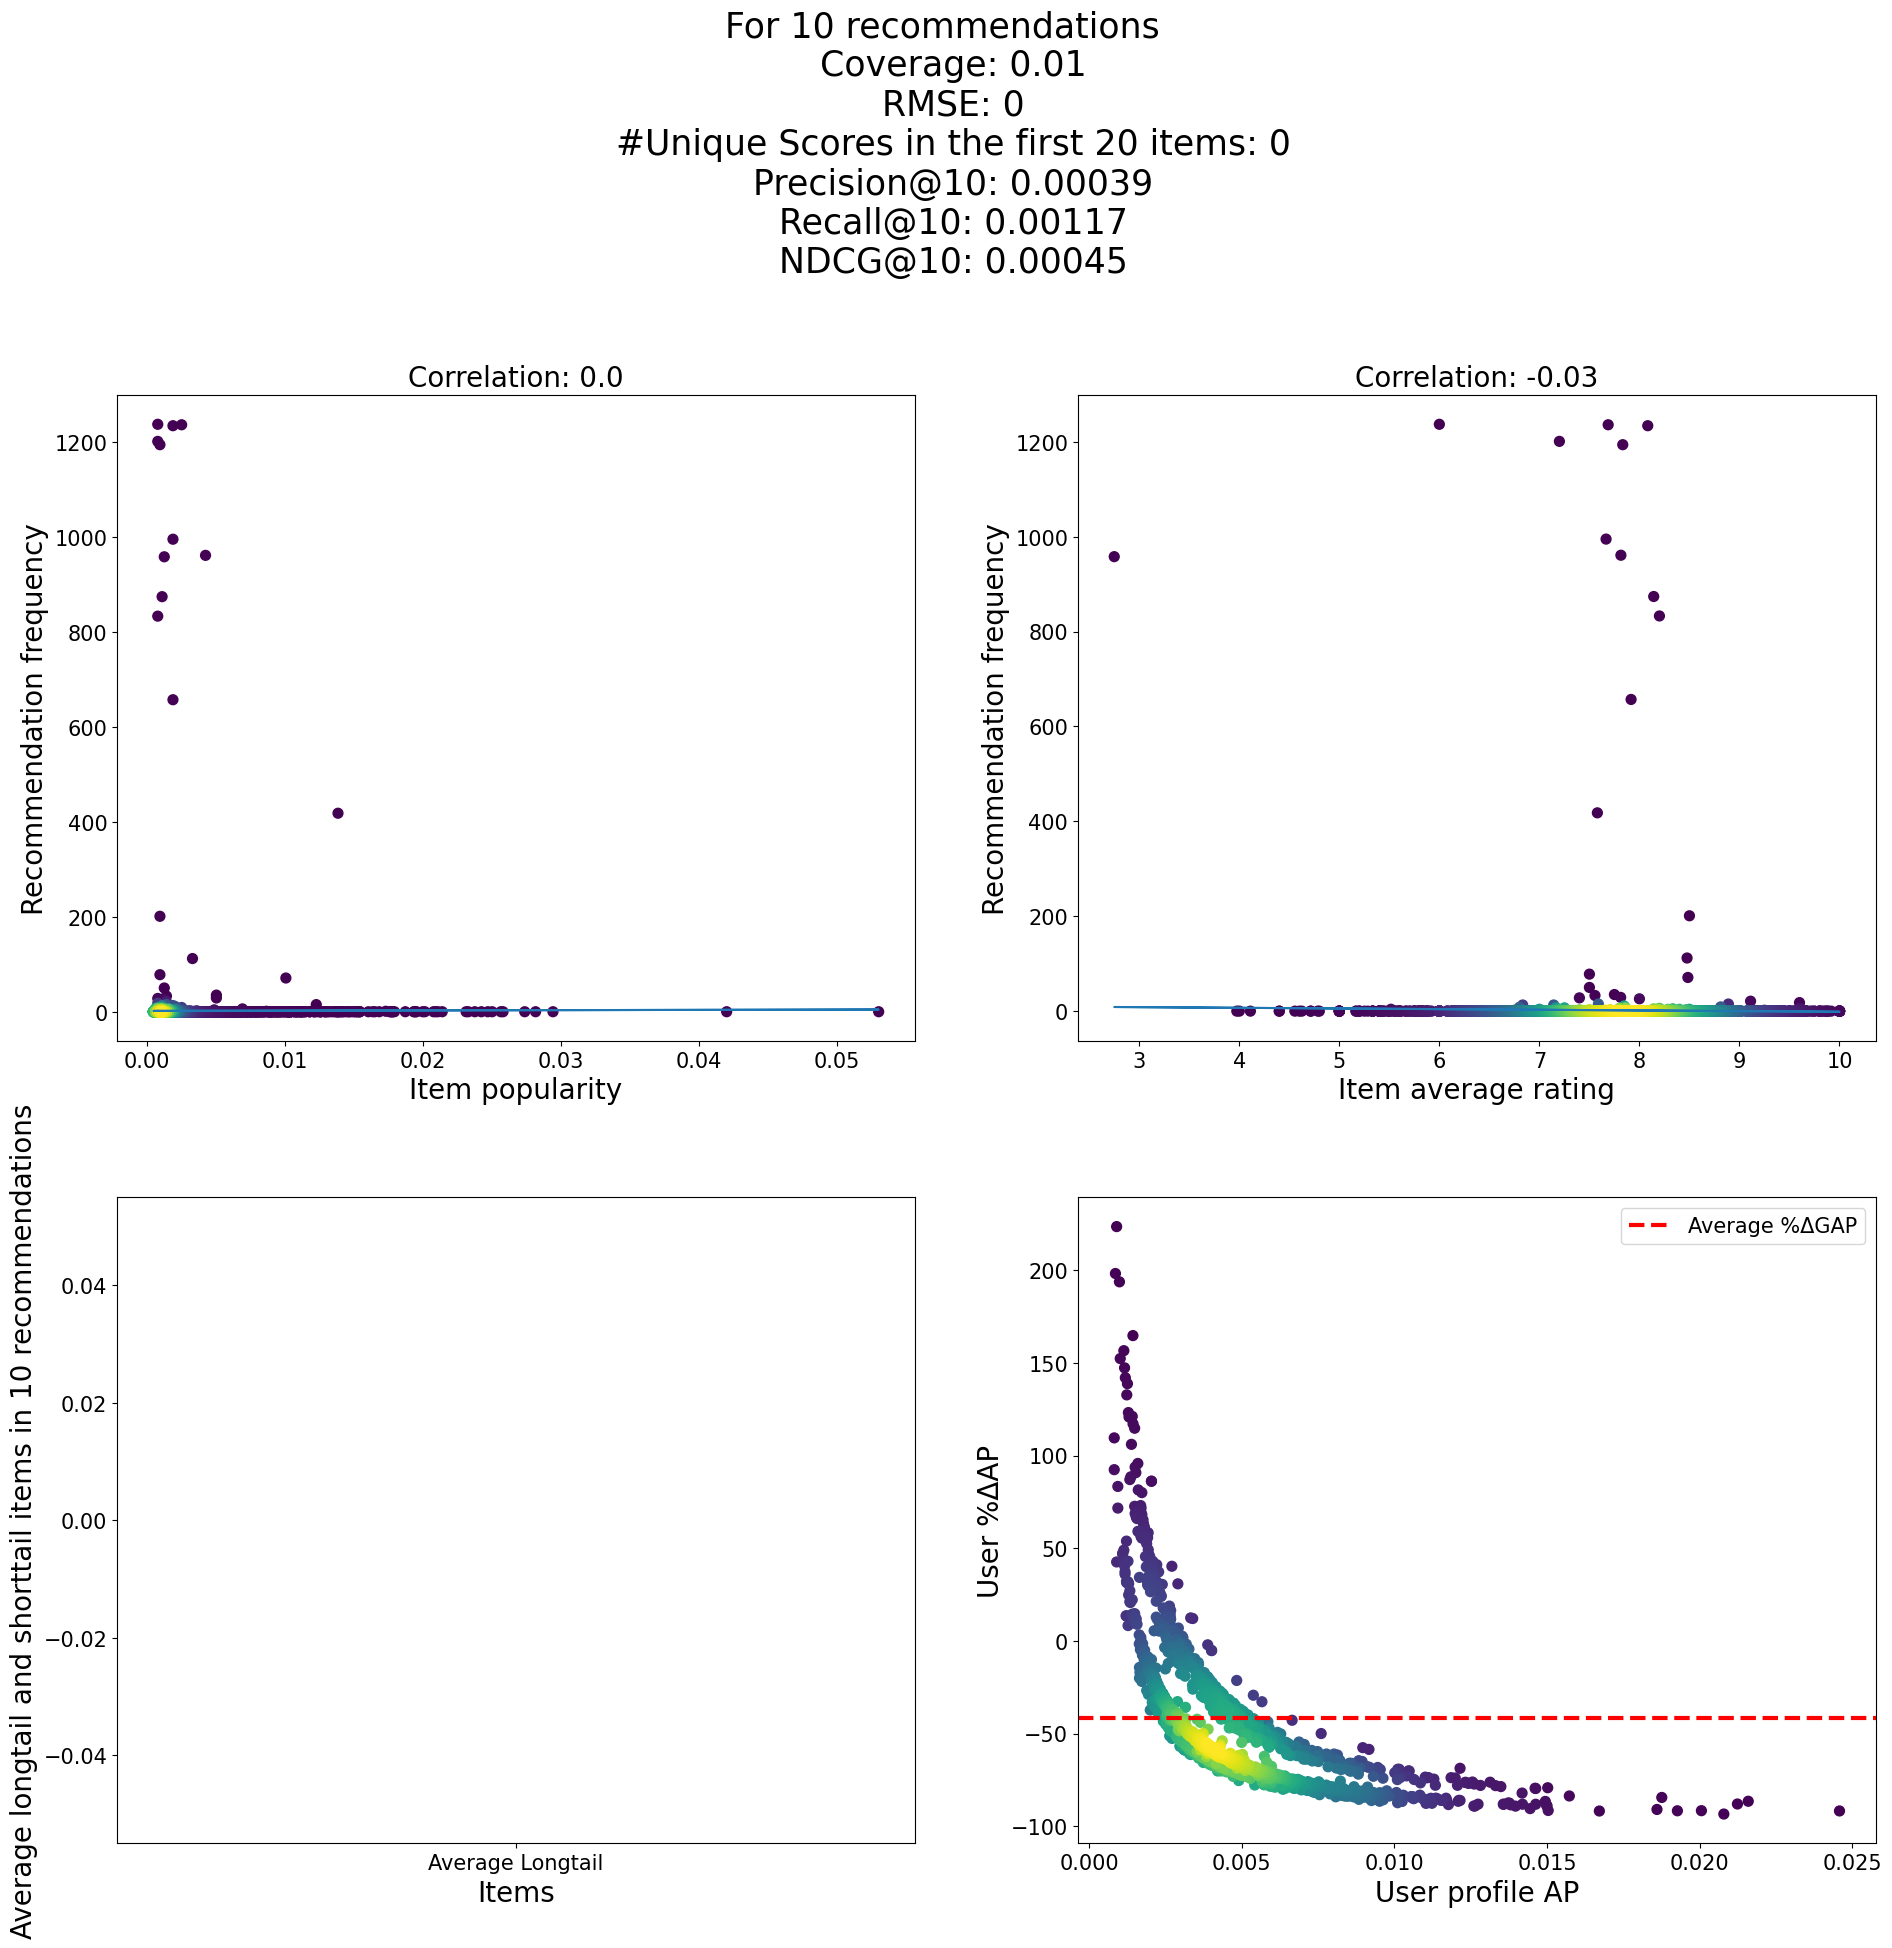

nr of longtail 6498
5.1084905660377355


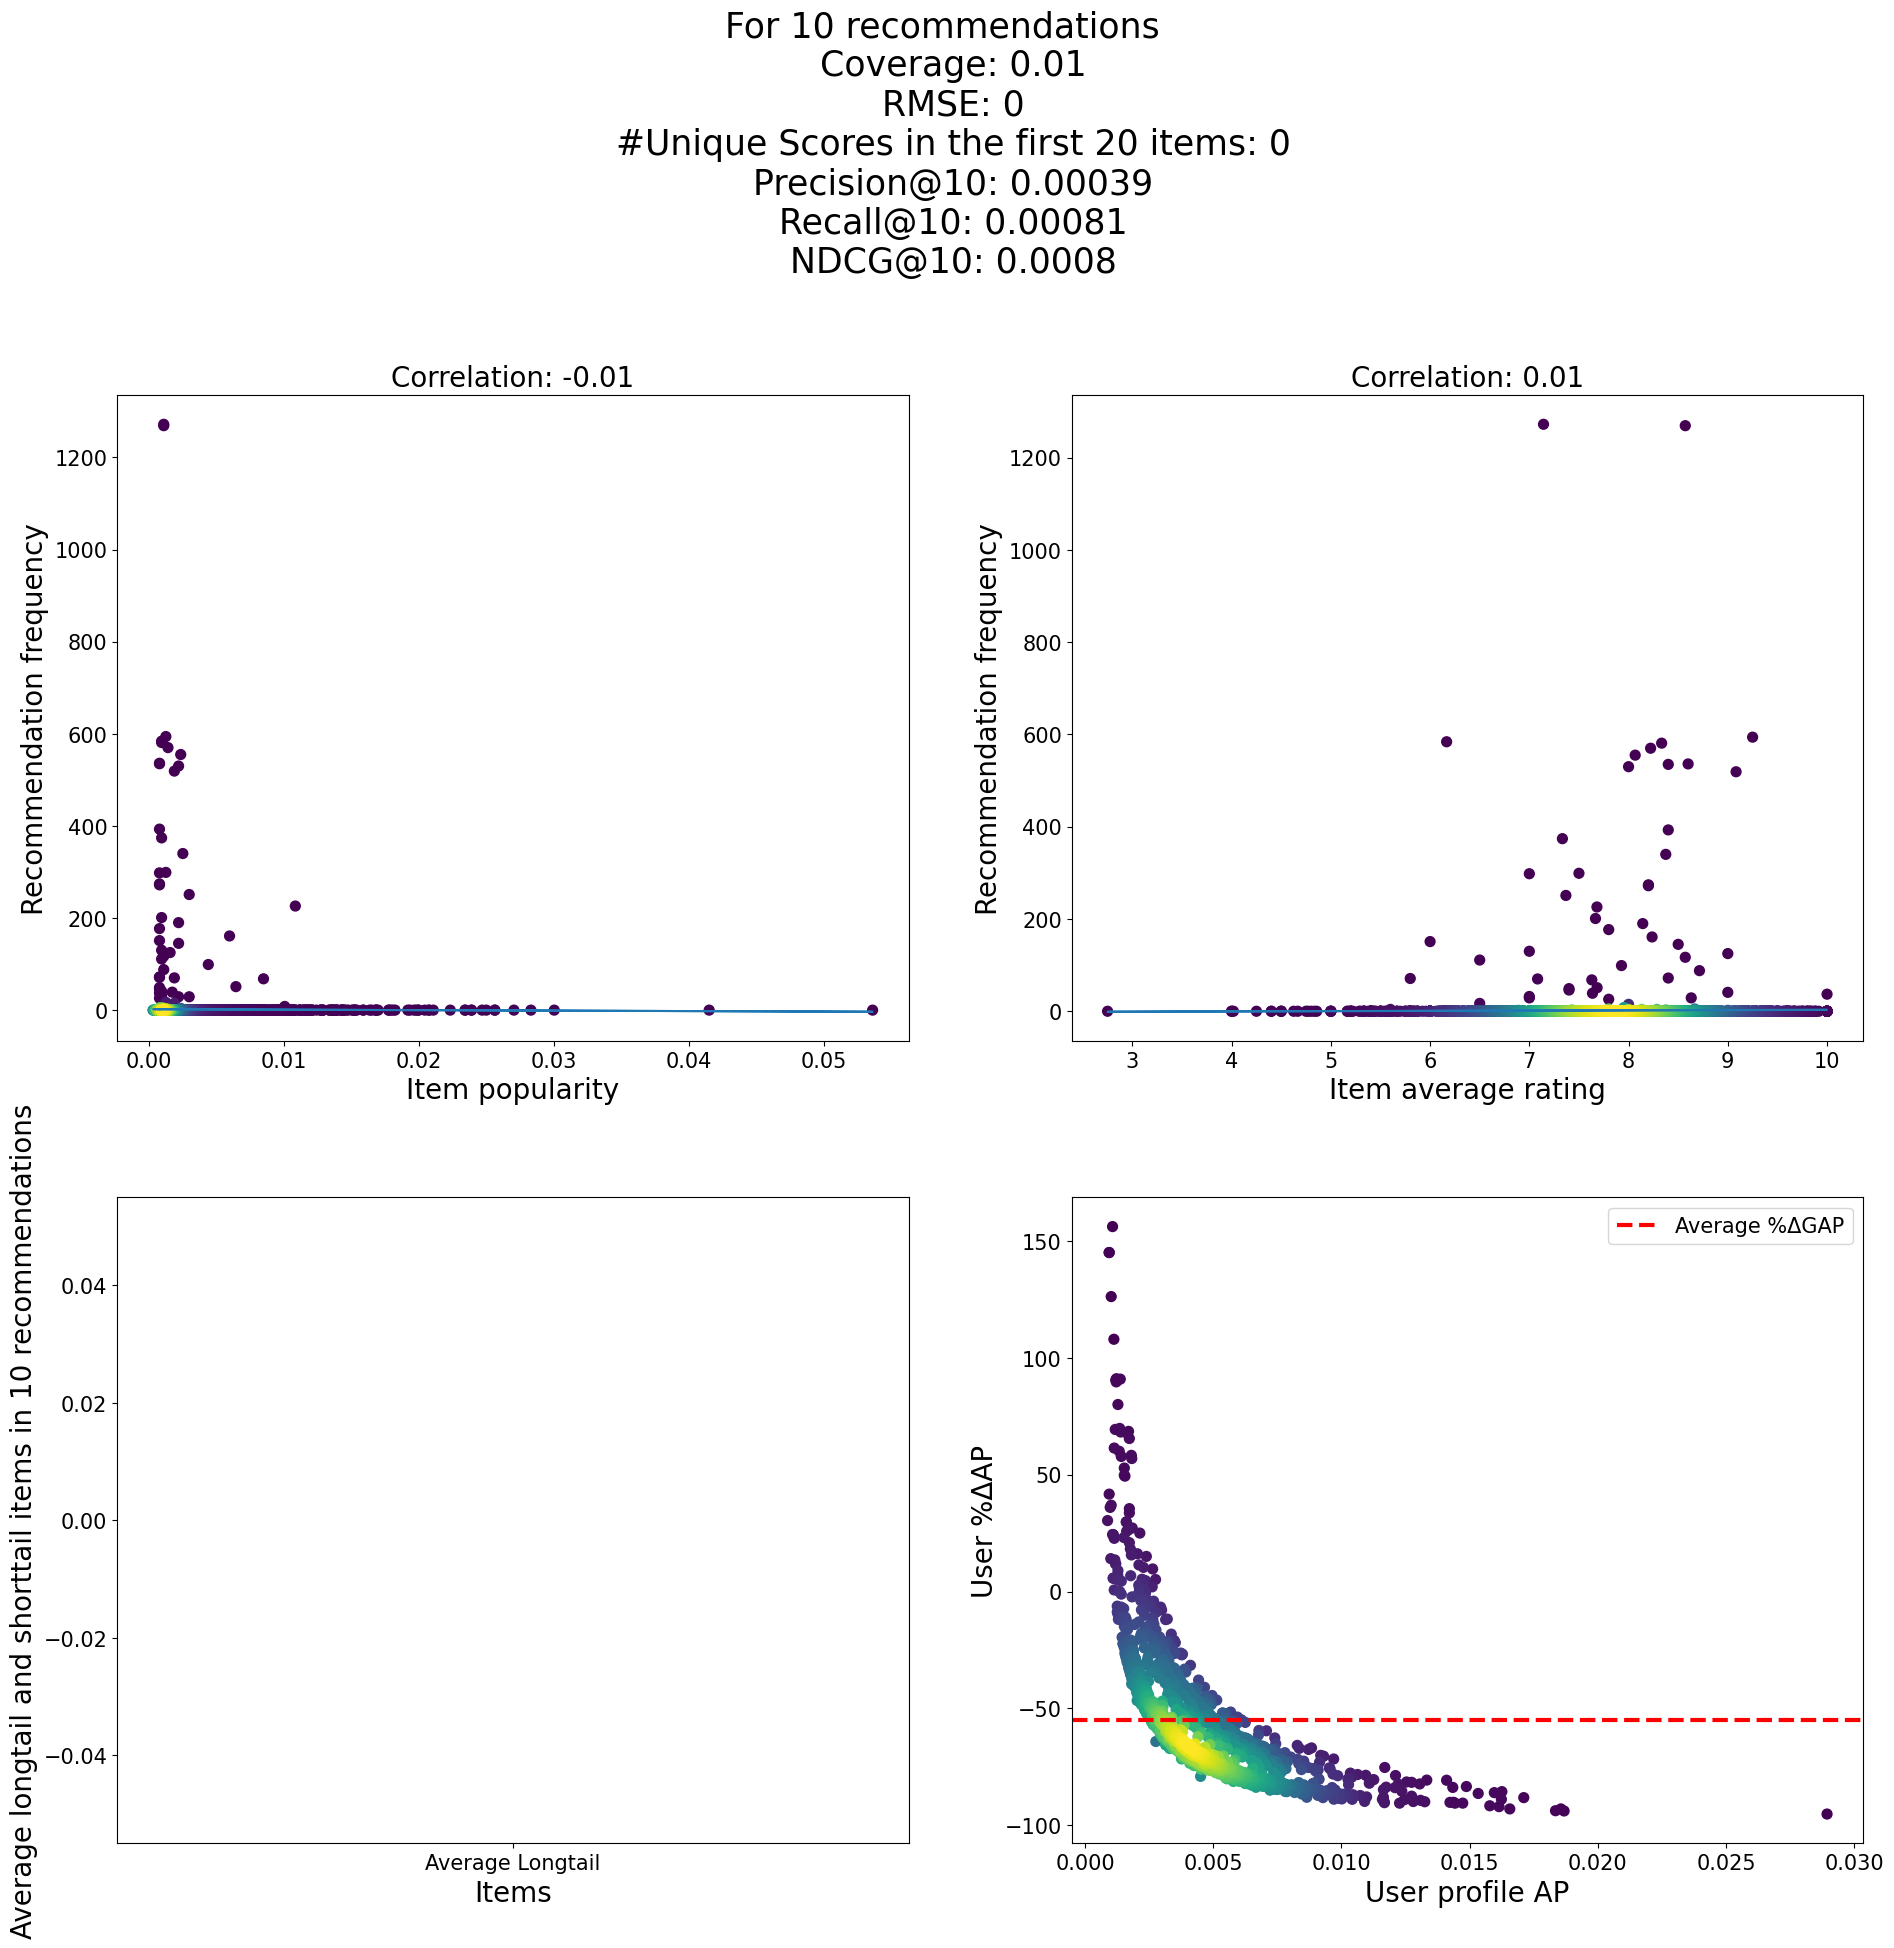

nr of longtail 7252
5.70125786163522


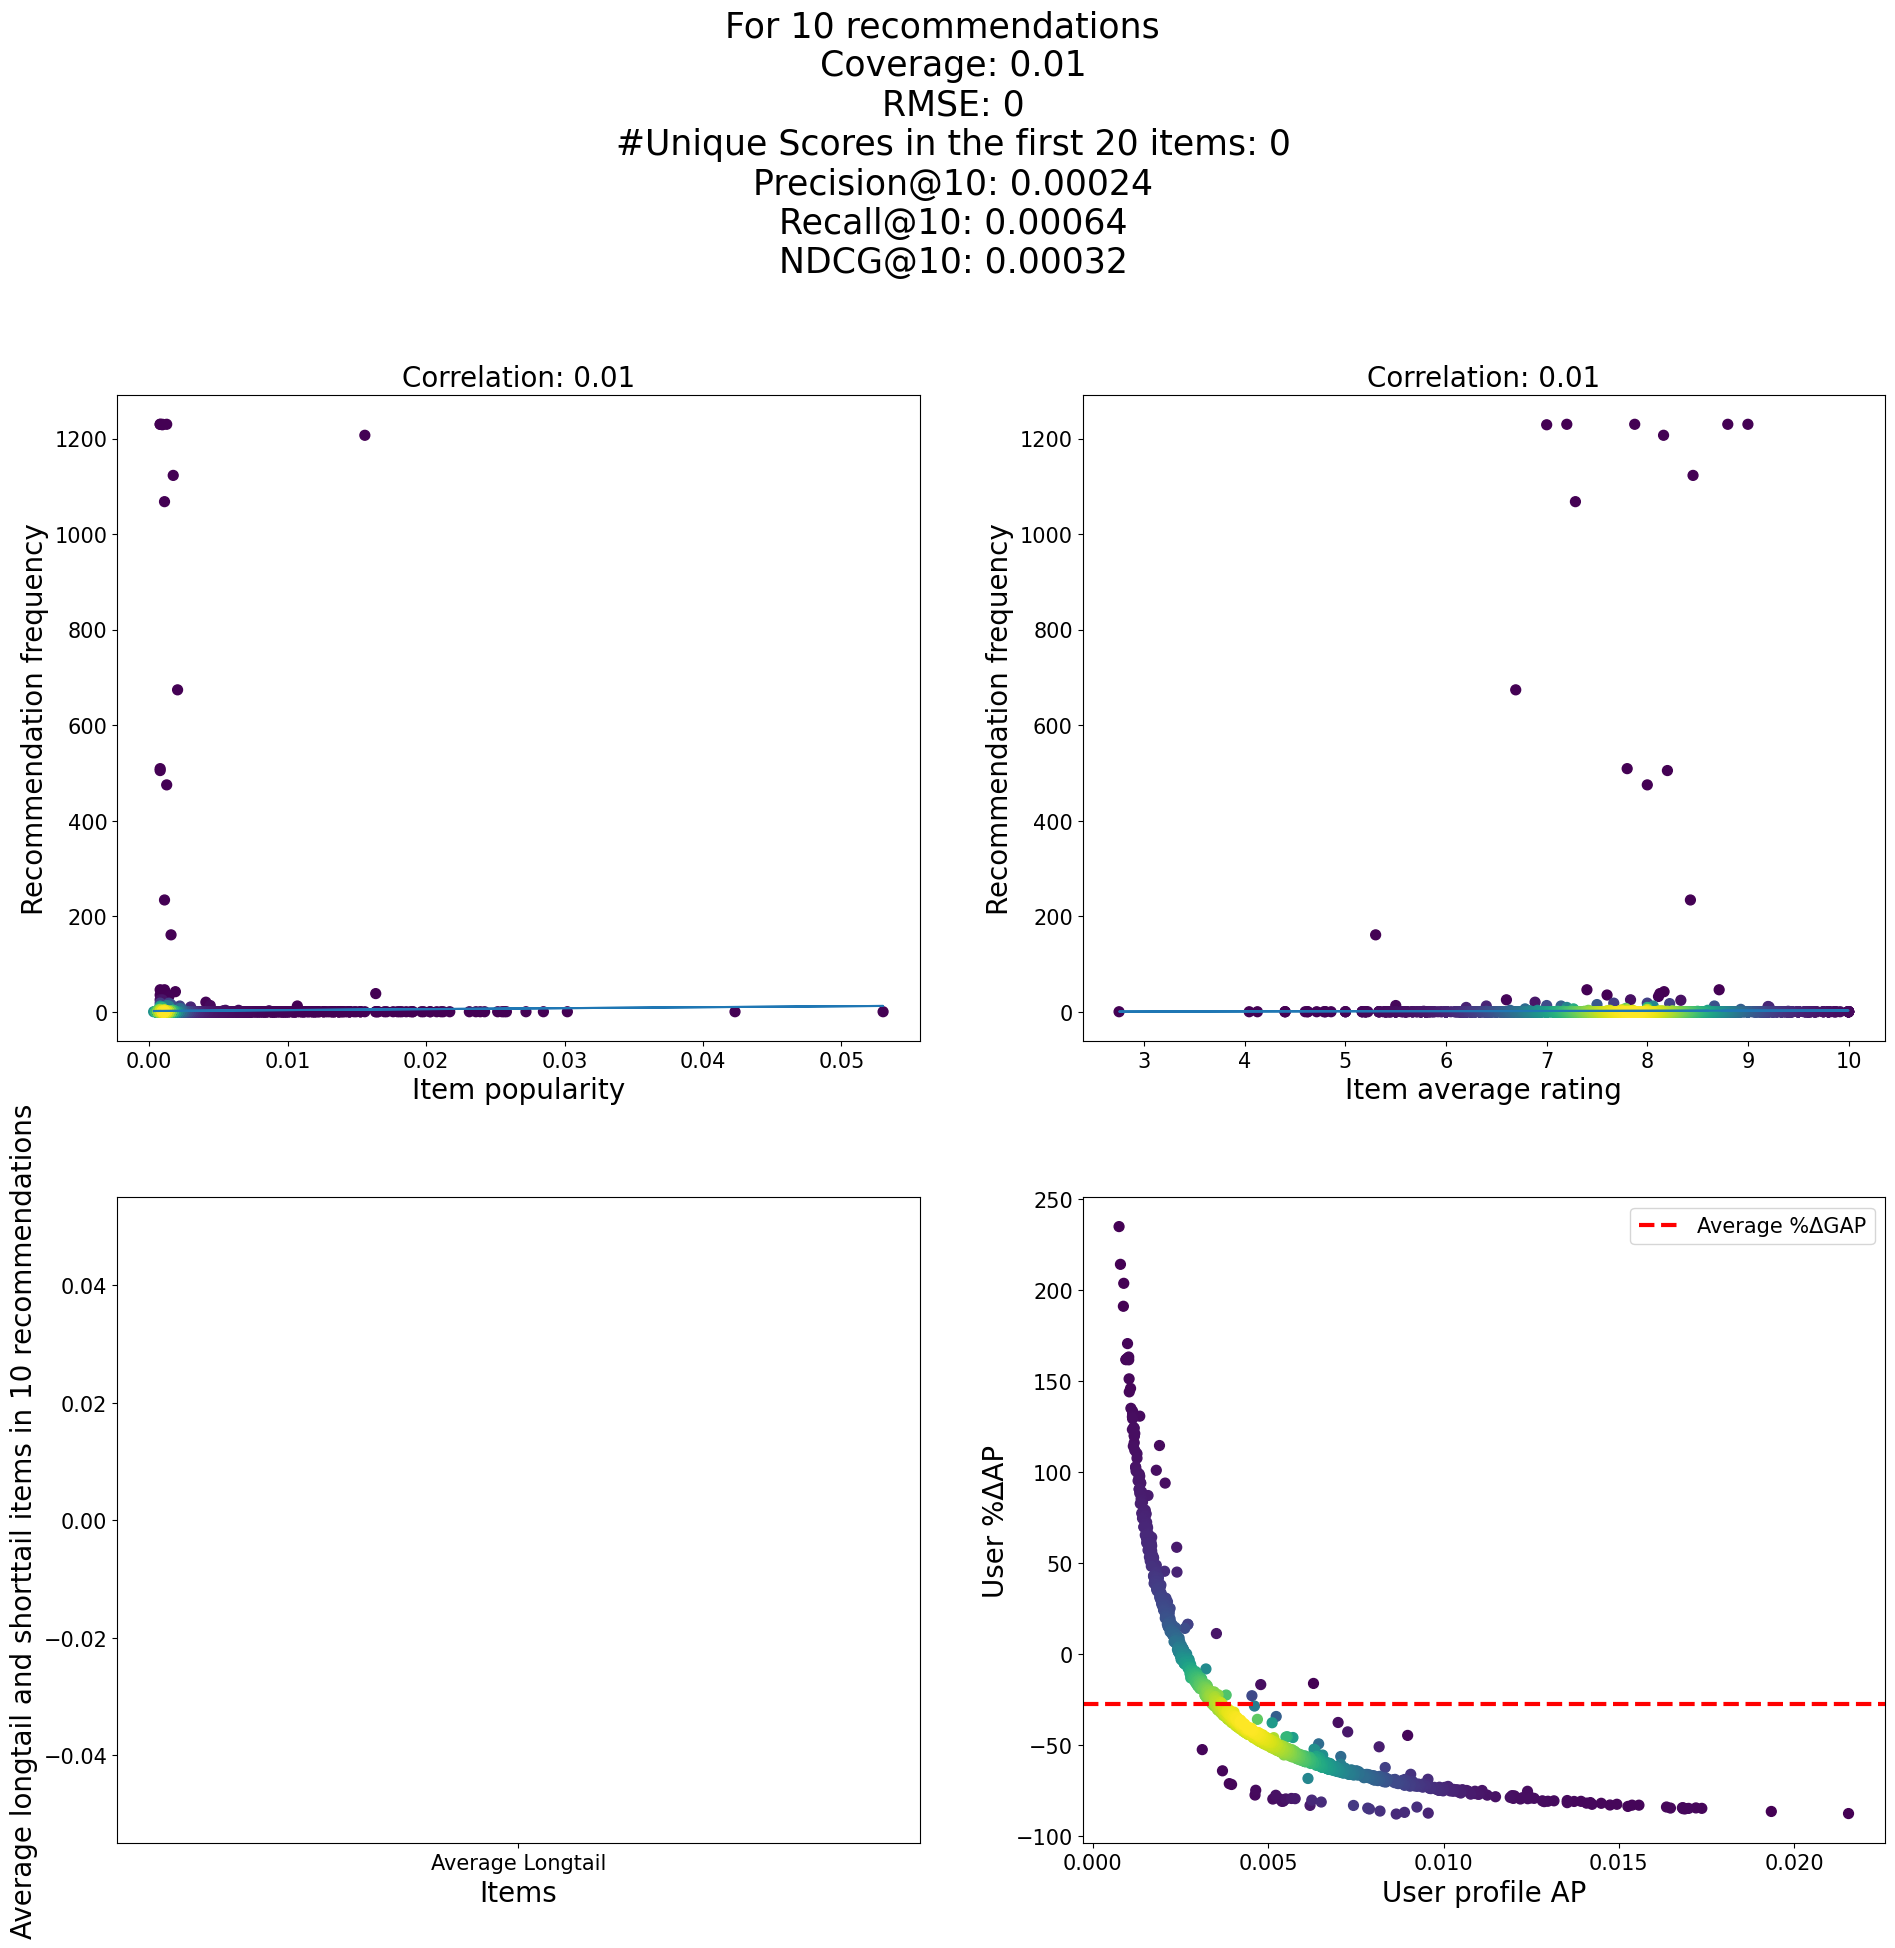

nr of longtail 8393
6.603461841070024


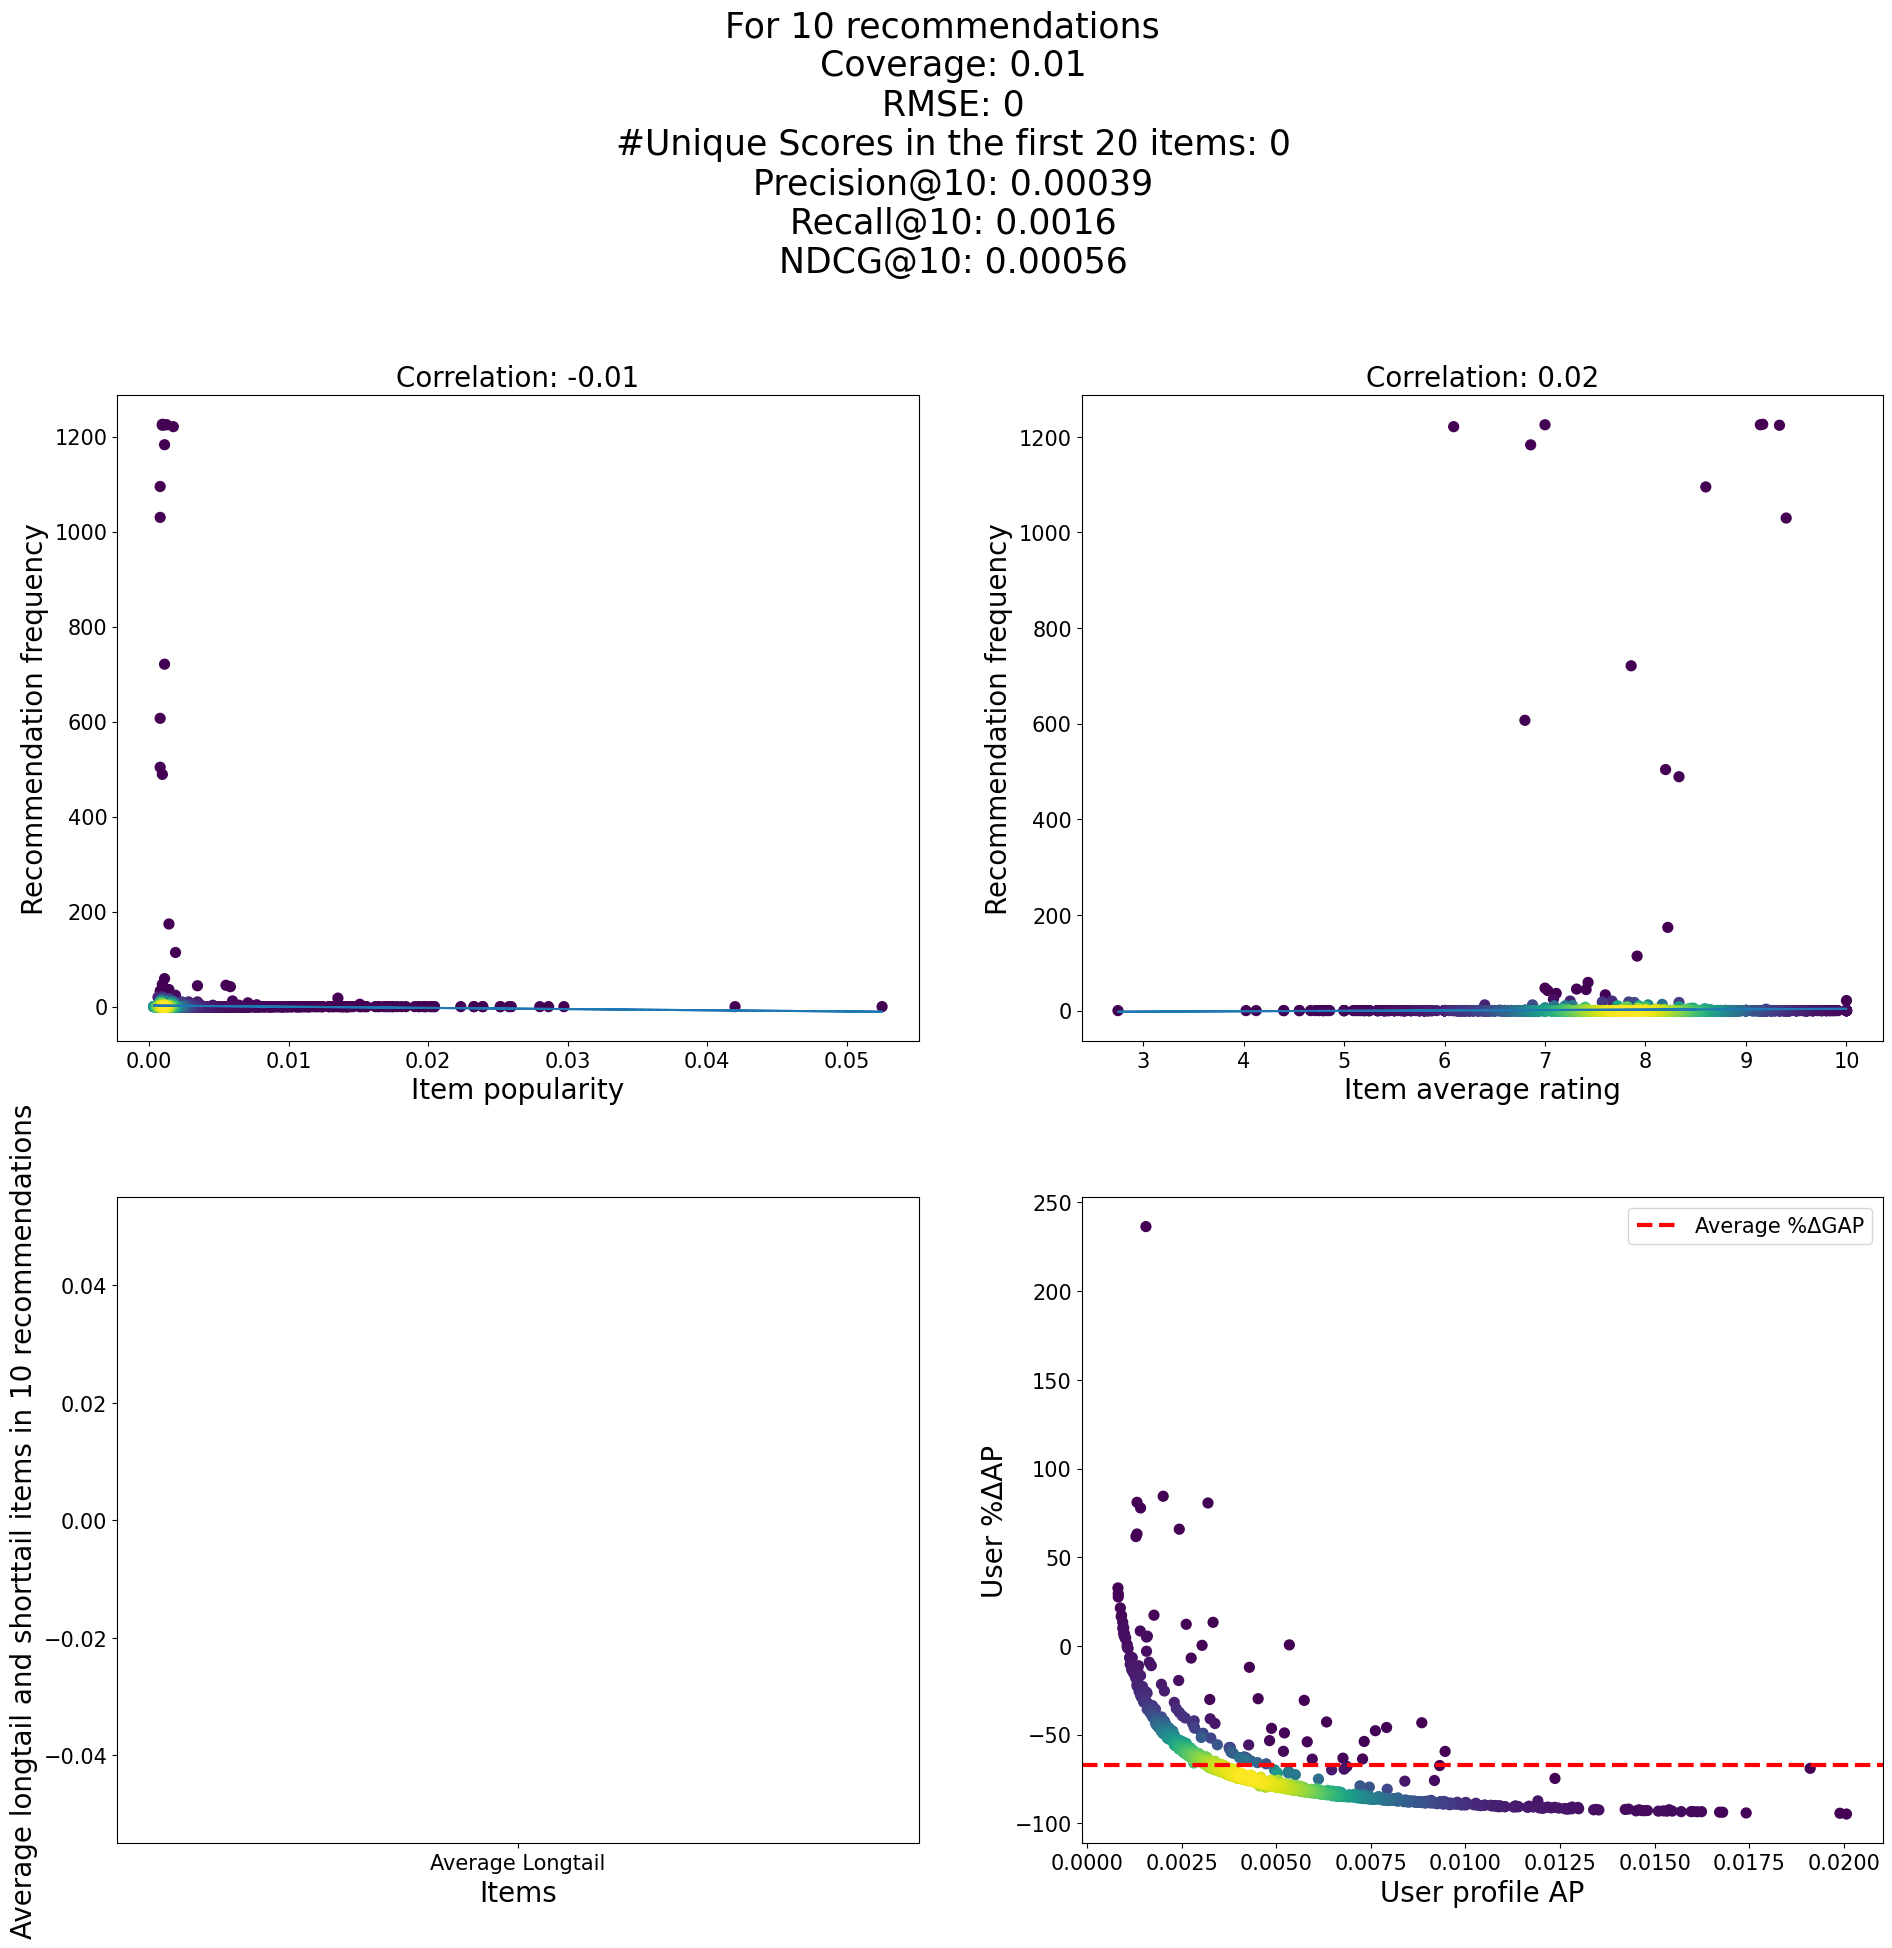

nr of longtail 4163
3.2753737214791503


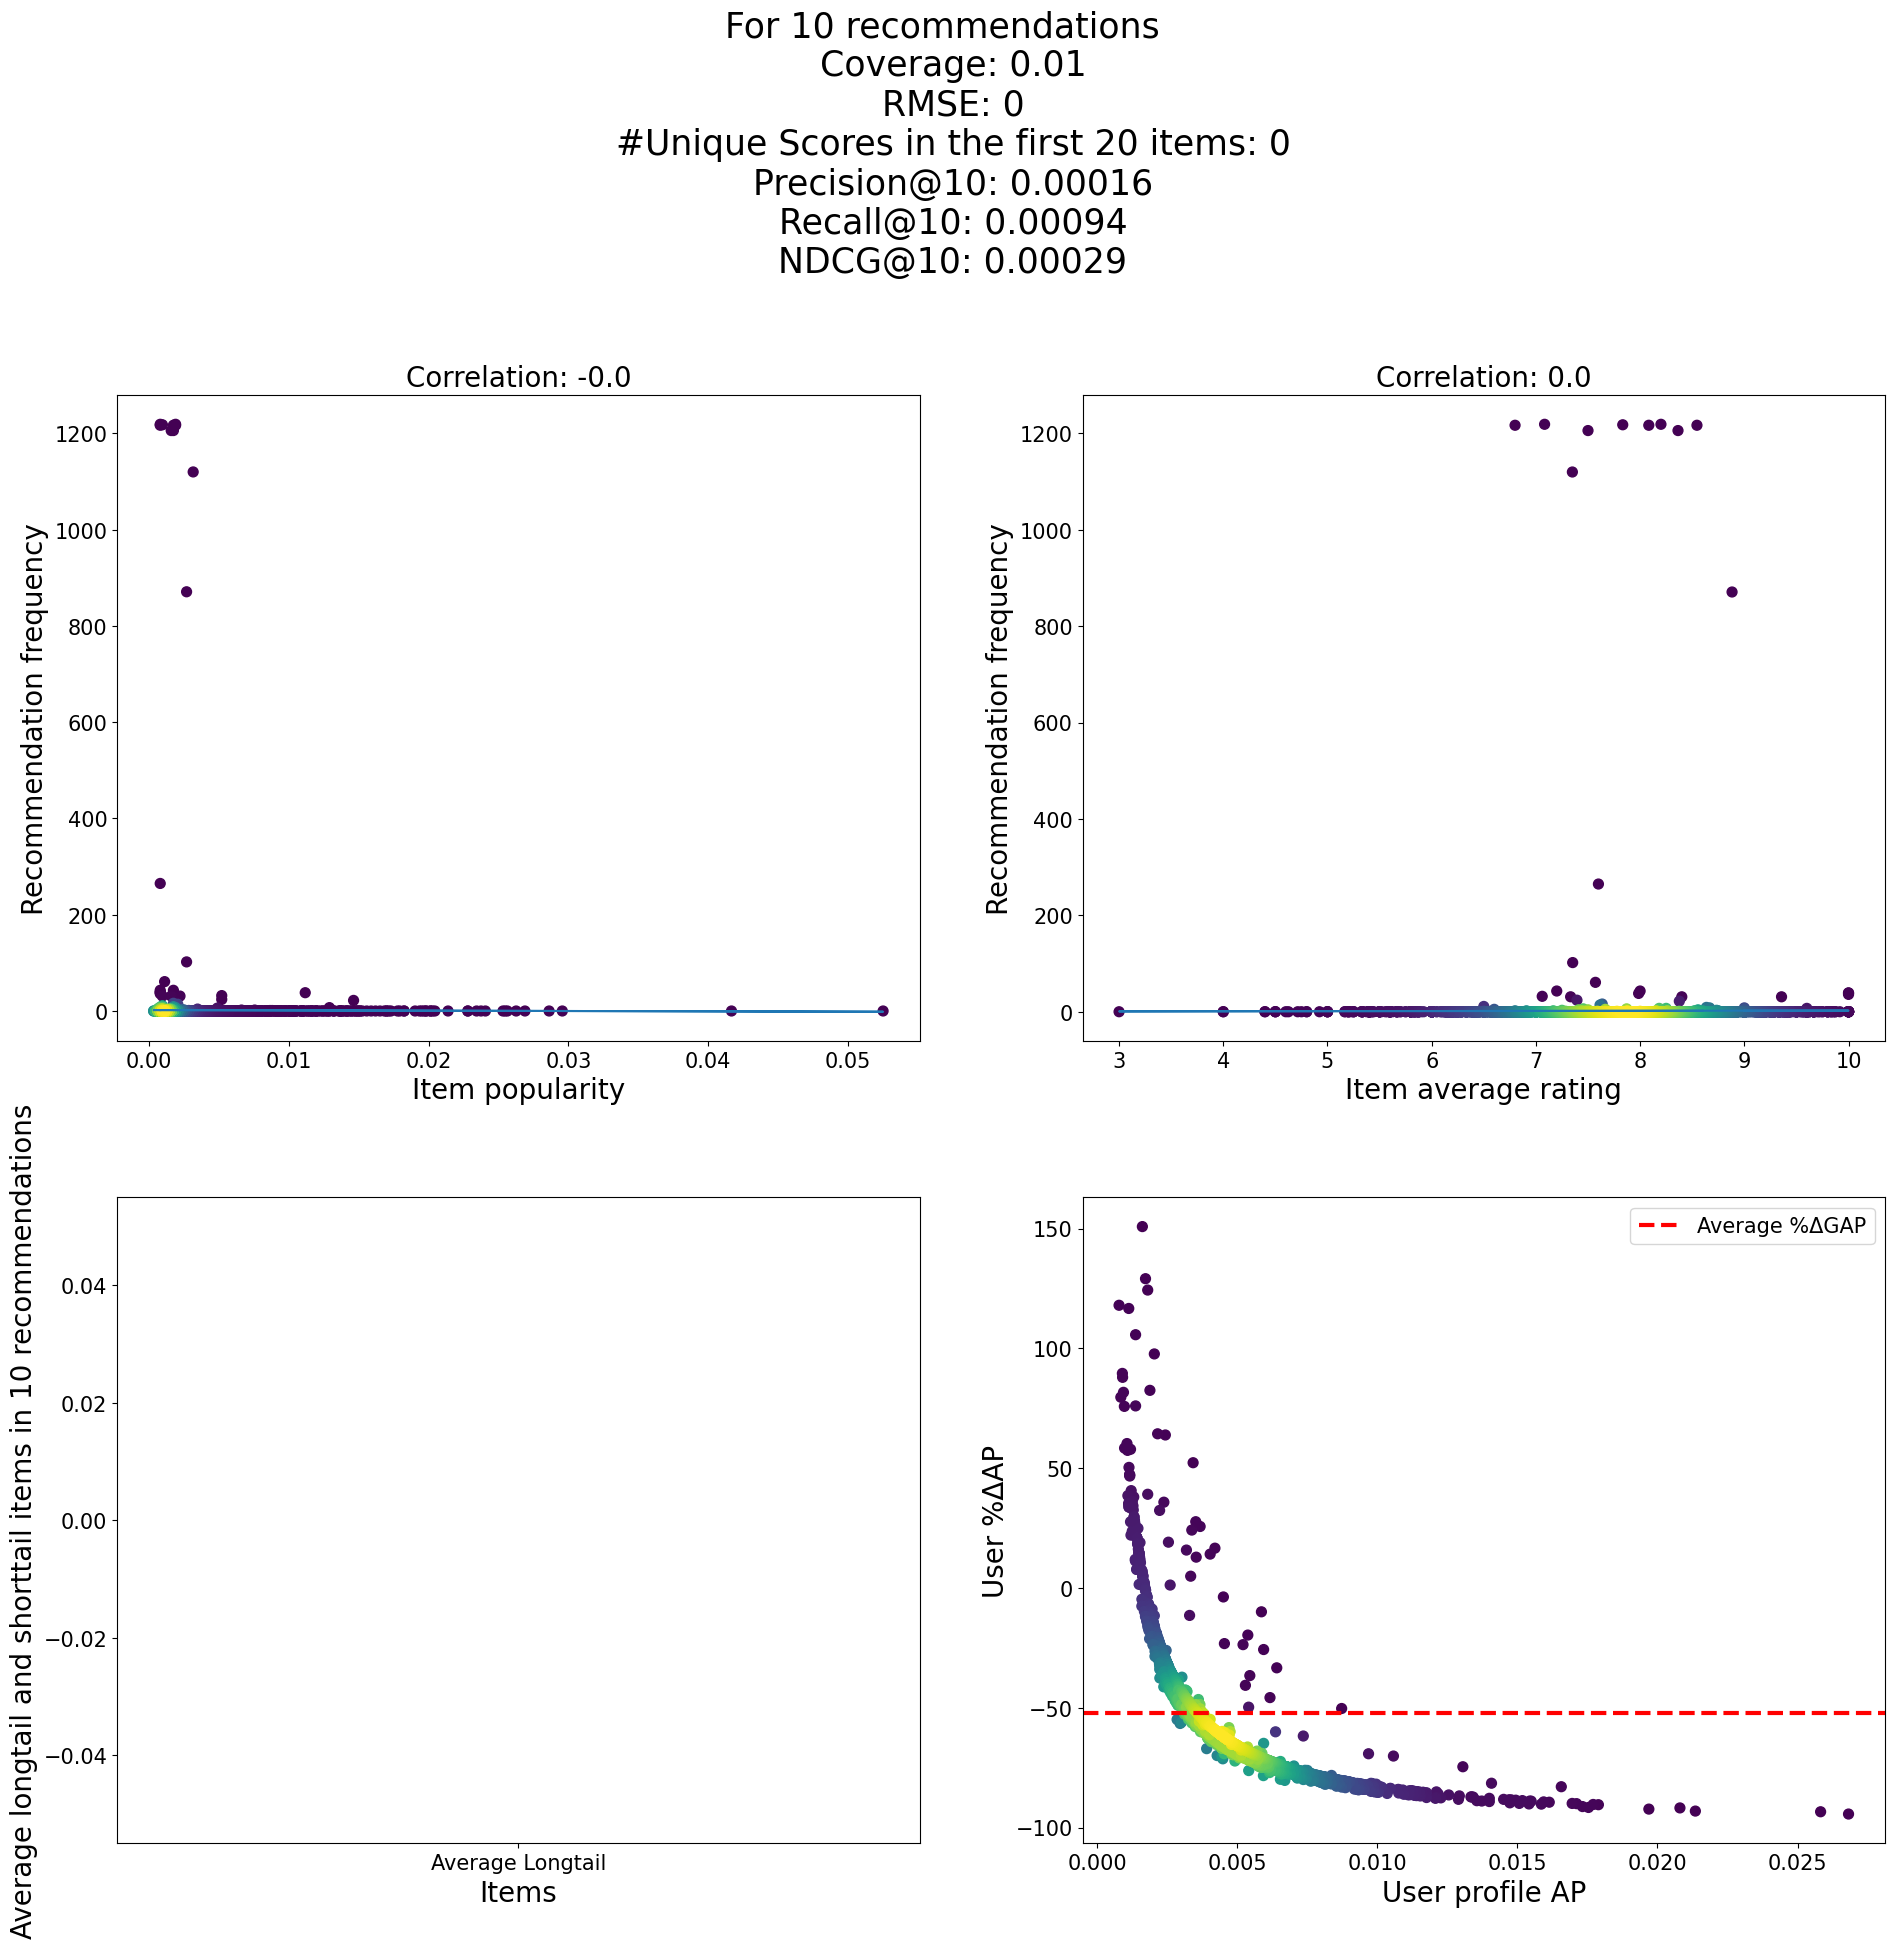

{'64-32': [{'pop_corr': (0.0030702361054695286, 0.7984333000476885), 'RMSE': 0, 'NDCG': 0.00044599829166003057, 'ARP': 0.002101658189256936, 'ave_PL': -41.64336511446936, 'ACLT': 4.514150943396227, 'AggDiv': 0.011125559890189278}, {'pop_corr': (-0.007721083142620722, 0.520723773848944), 'RMSE': 0, 'NDCG': 0.0007995678275370934, 'ARP': 0.0016115857603257228, 'ave_PL': -54.767156365727416, 'ACLT': 5.1084905660377355, 'AggDiv': 0.0109810720994076}, {'pop_corr': (0.011303300835455887, 0.34710955758989803), 'RMSE': 0, 'NDCG': 0.0003246986642048584, 'ARP': 0.002562598795950627, 'ave_PL': -27.552546840166794, 'ACLT': 5.70125786163522, 'AggDiv': 0.011125559890189278}, {'pop_corr': (-0.01397323808877188, 0.2451071111099814), 'RMSE': 0, 'NDCG': 0.0005619717302224863, 'ARP': 0.001152948799272567, 'ave_PL': -67.28143217913939, 'ACLT': 6.603461841070024, 'AggDiv': 0.010692096517844241}, {'pop_corr': (-0.0035844193480931916, 0.7655932043860816), 'RMSE': 0, 'NDCG': 0.0002936935331568753, 'ARP': 0.001

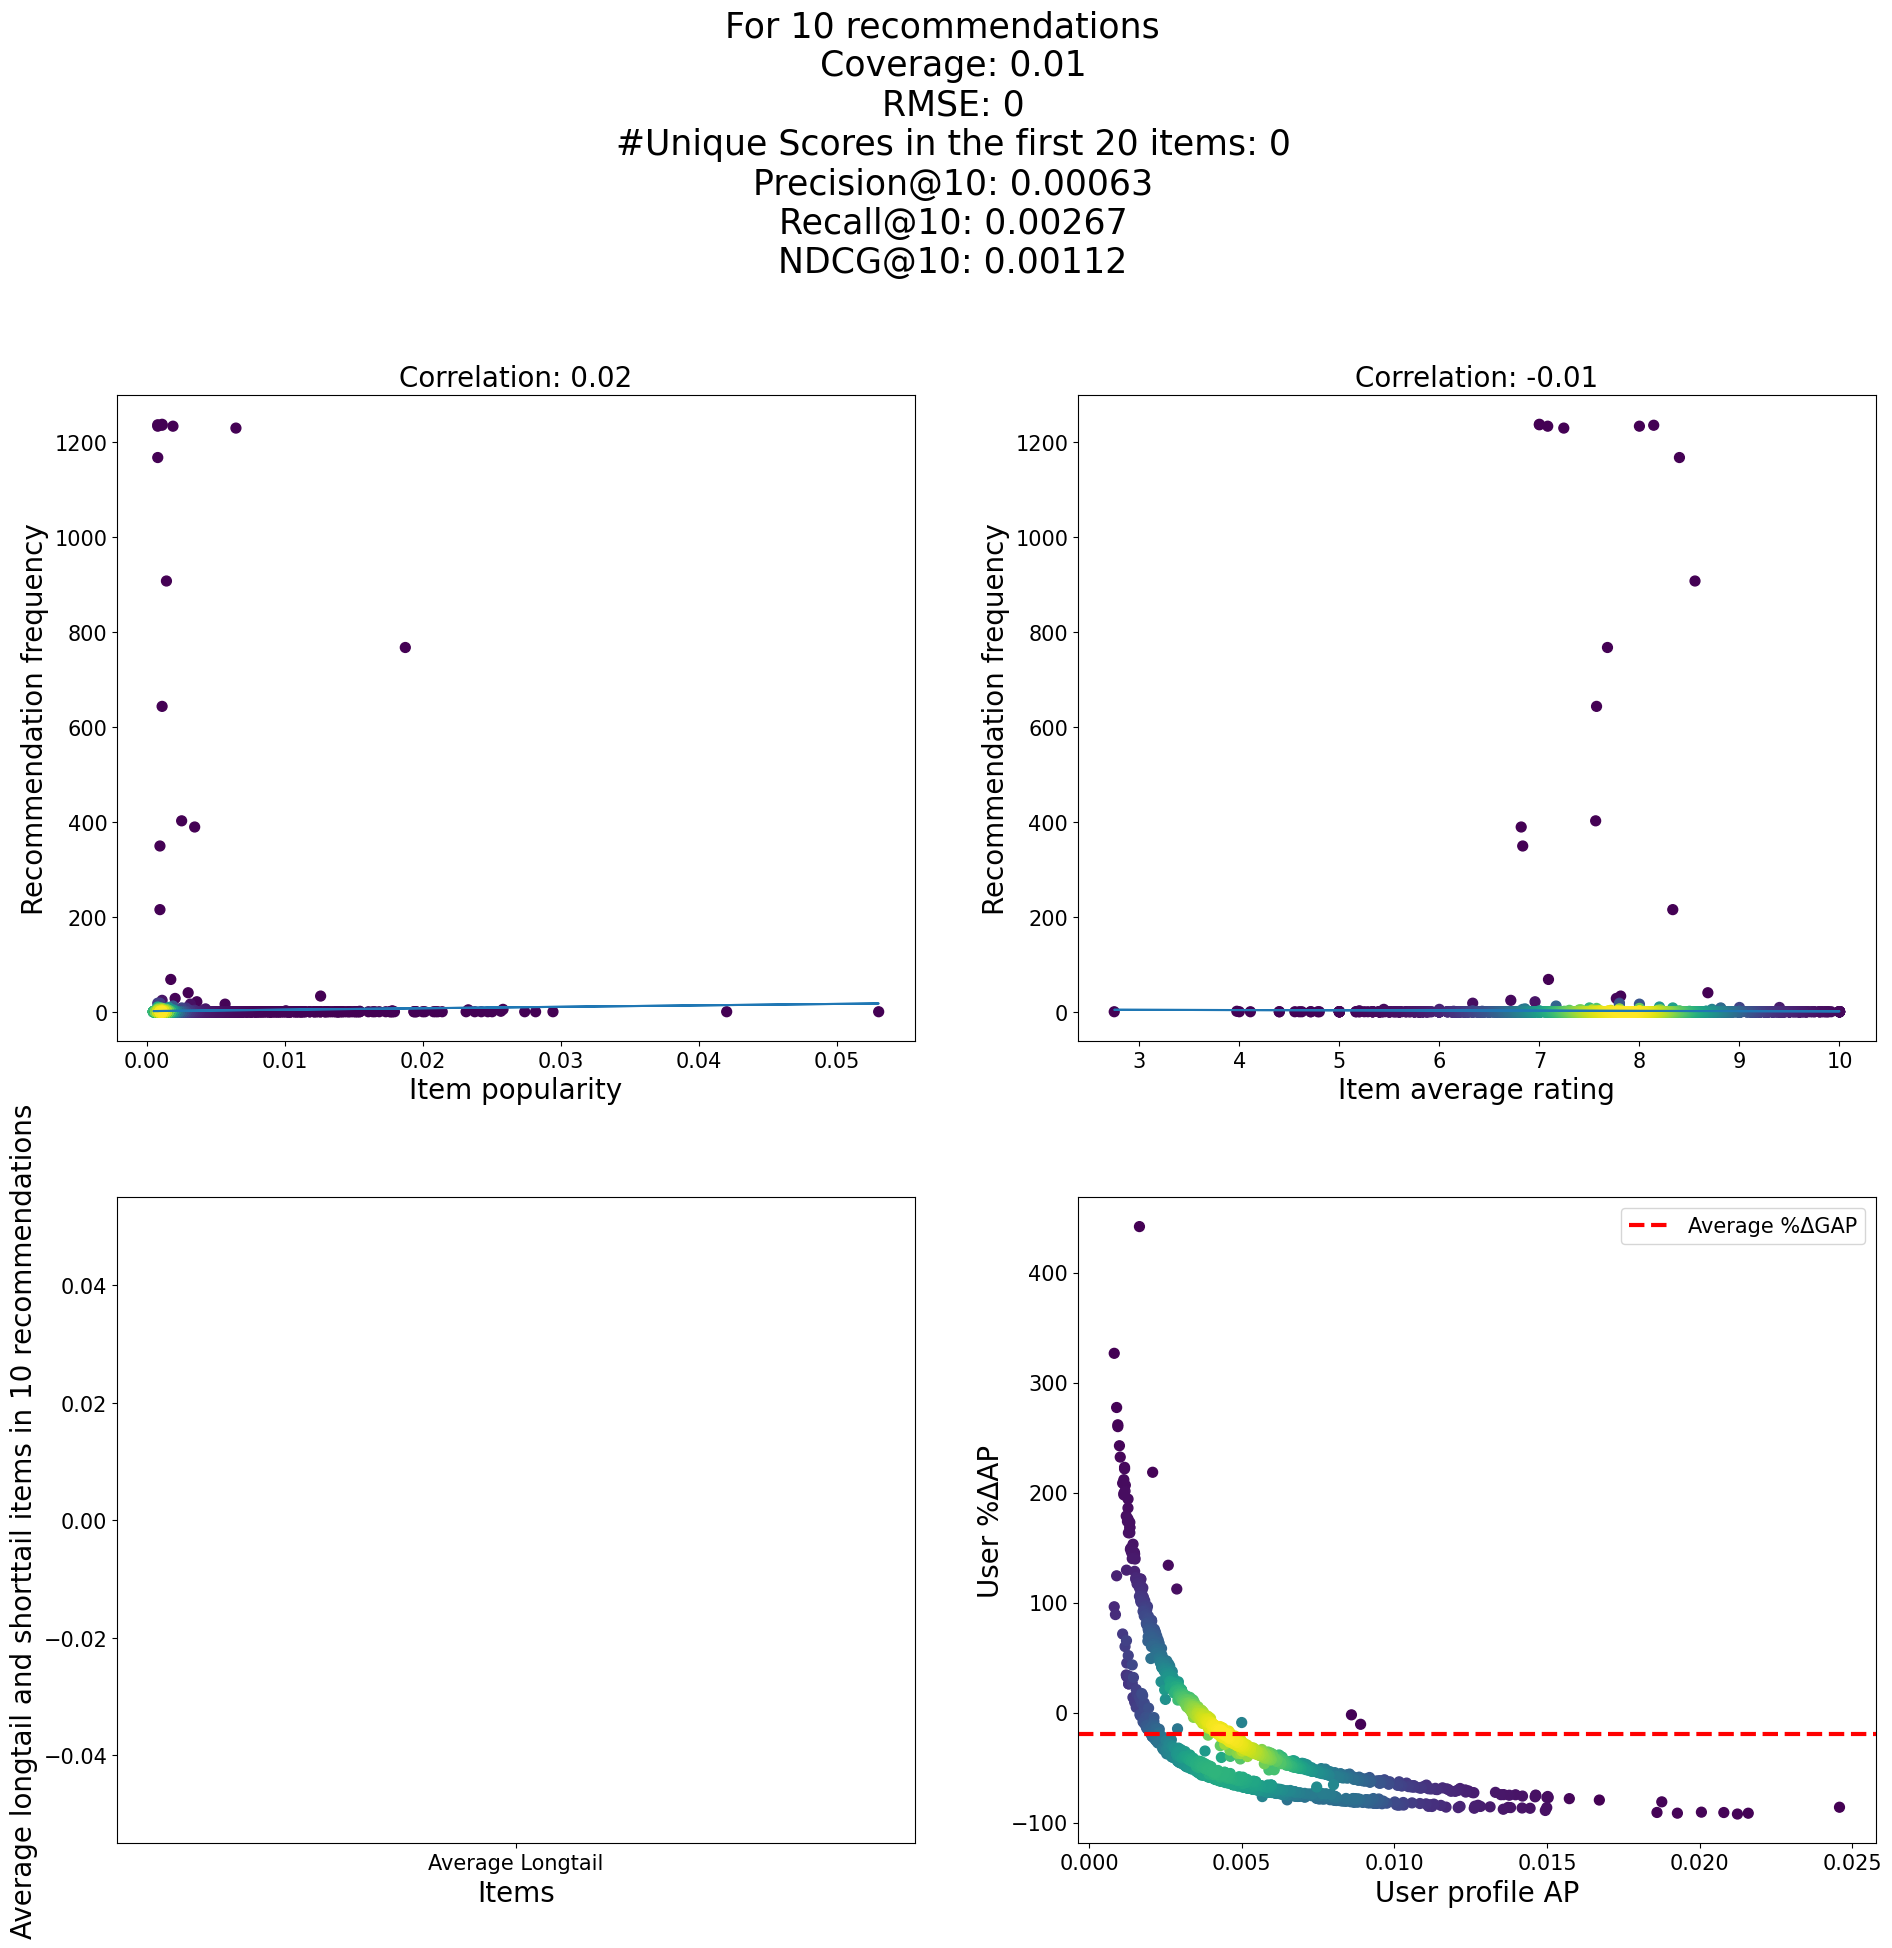

nr of longtail 5067
3.983490566037736


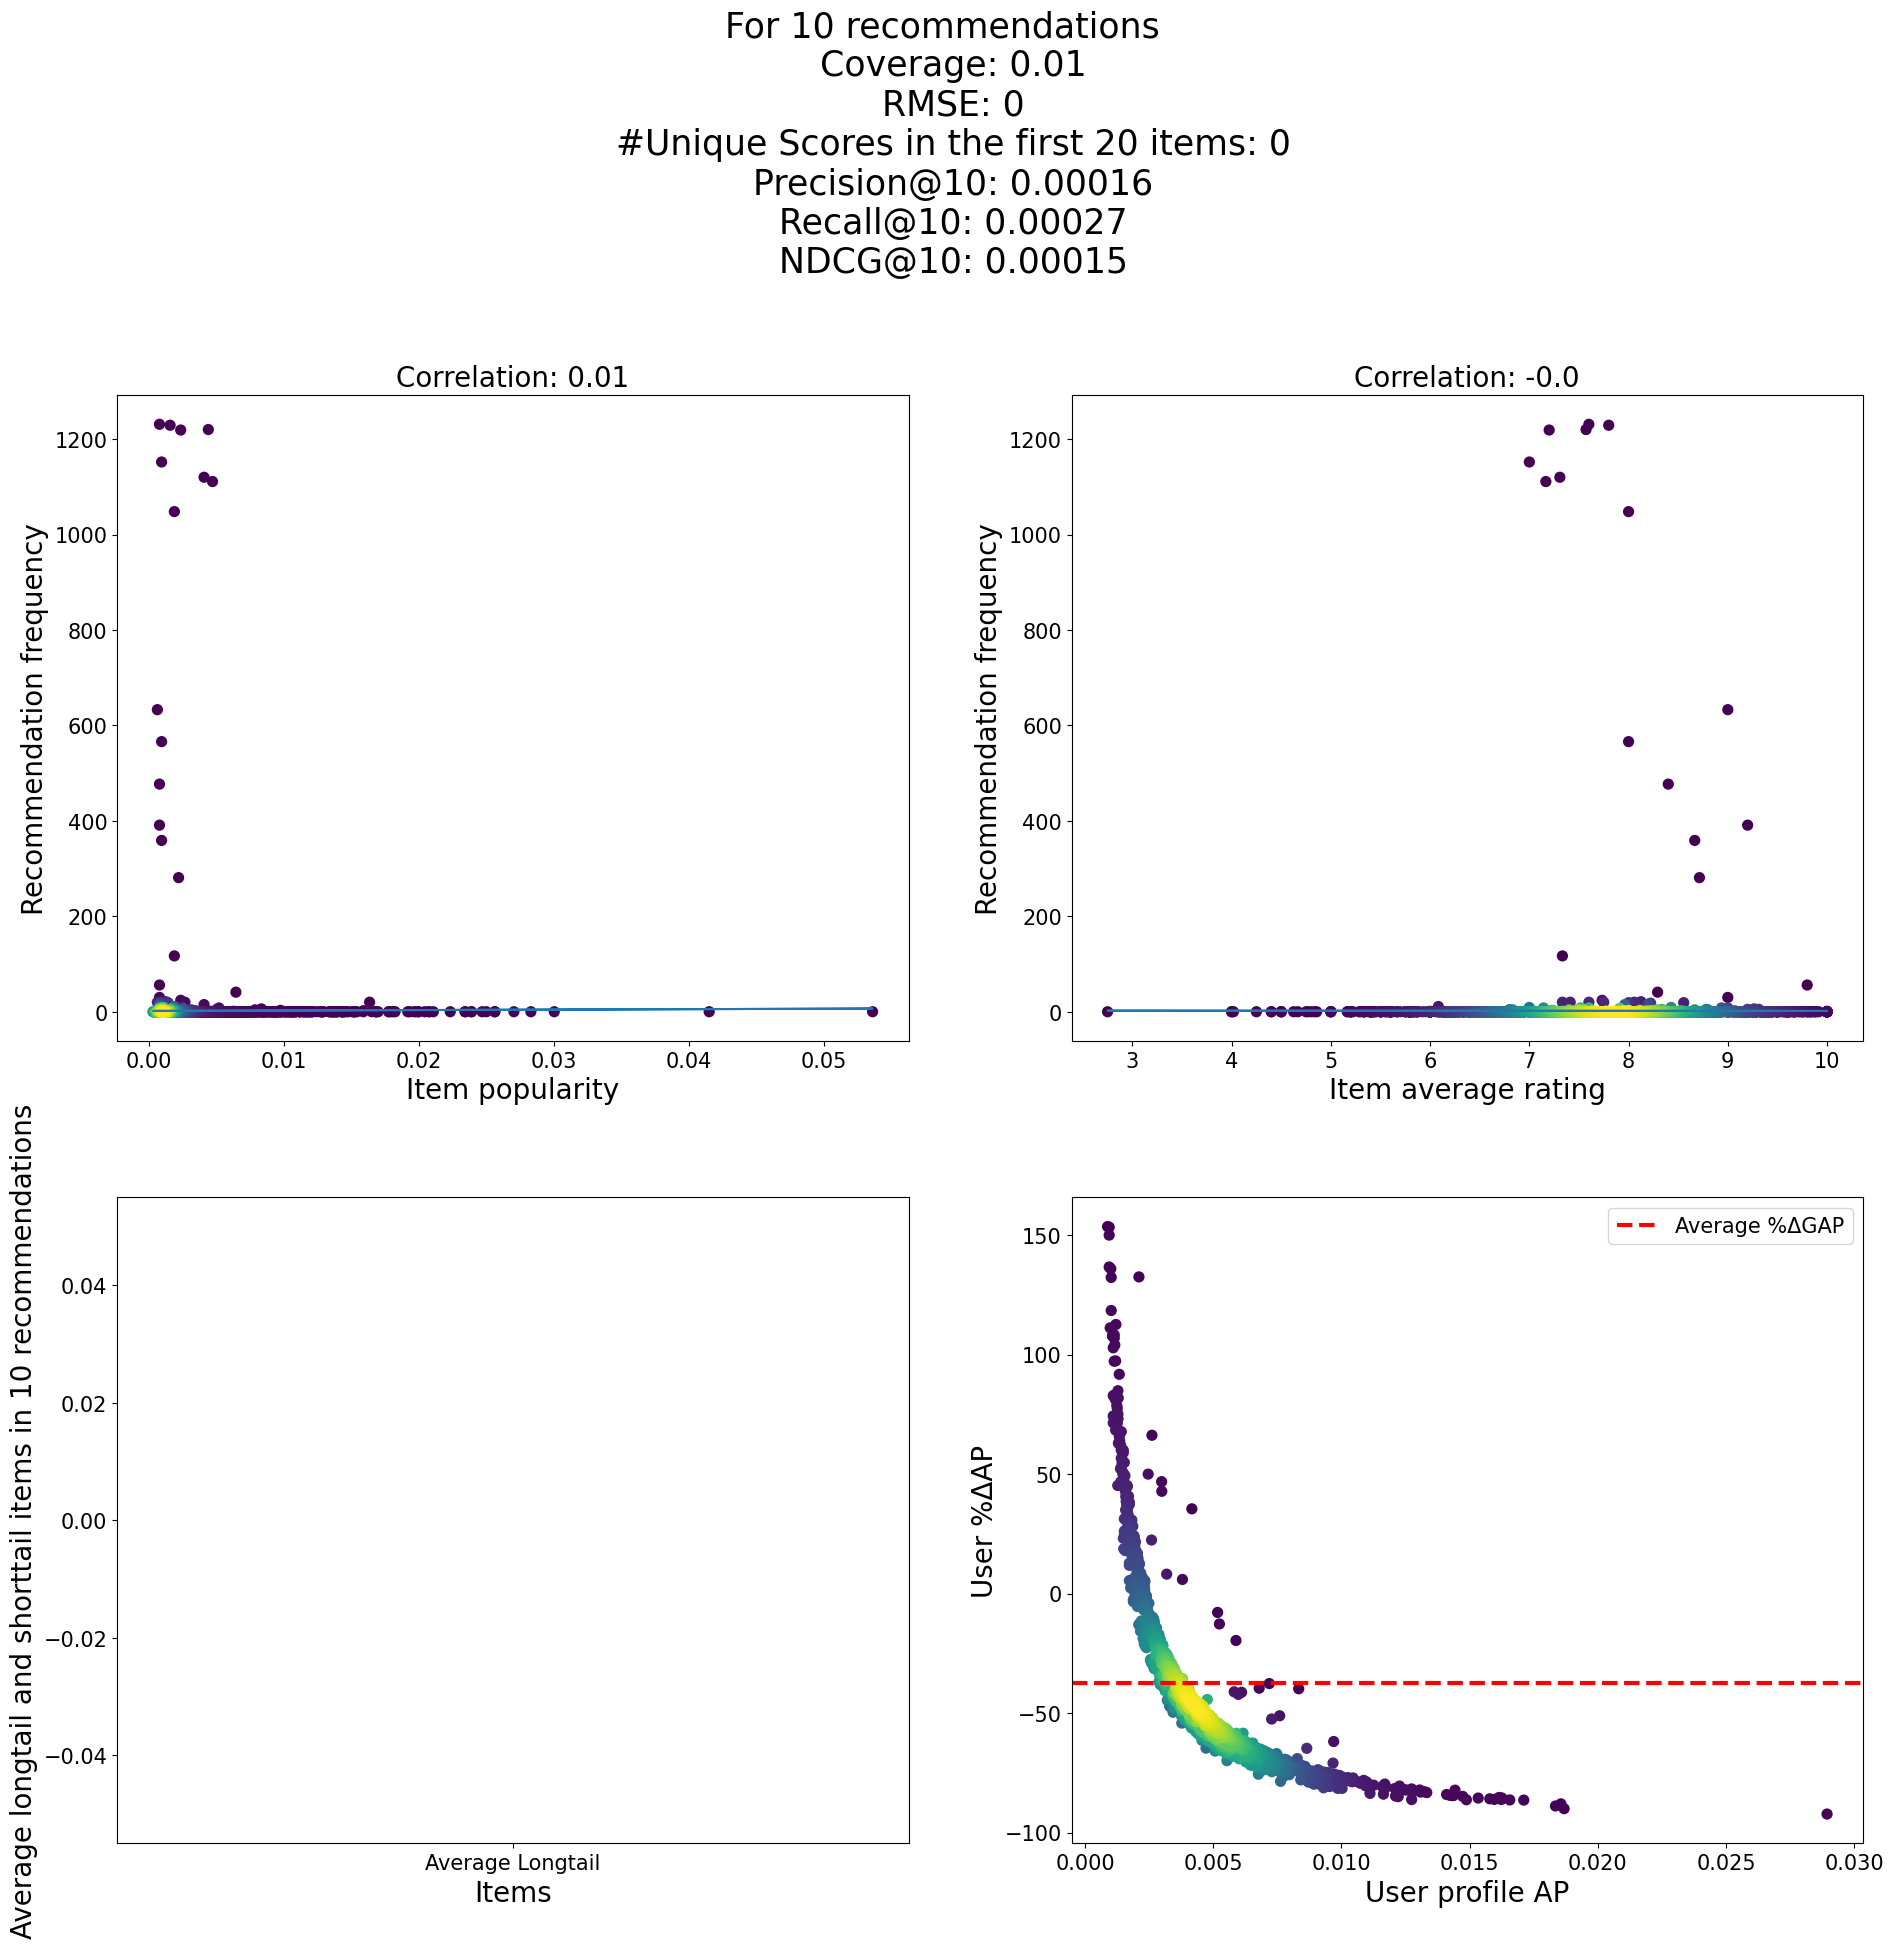

nr of longtail 5338
4.196540880503145


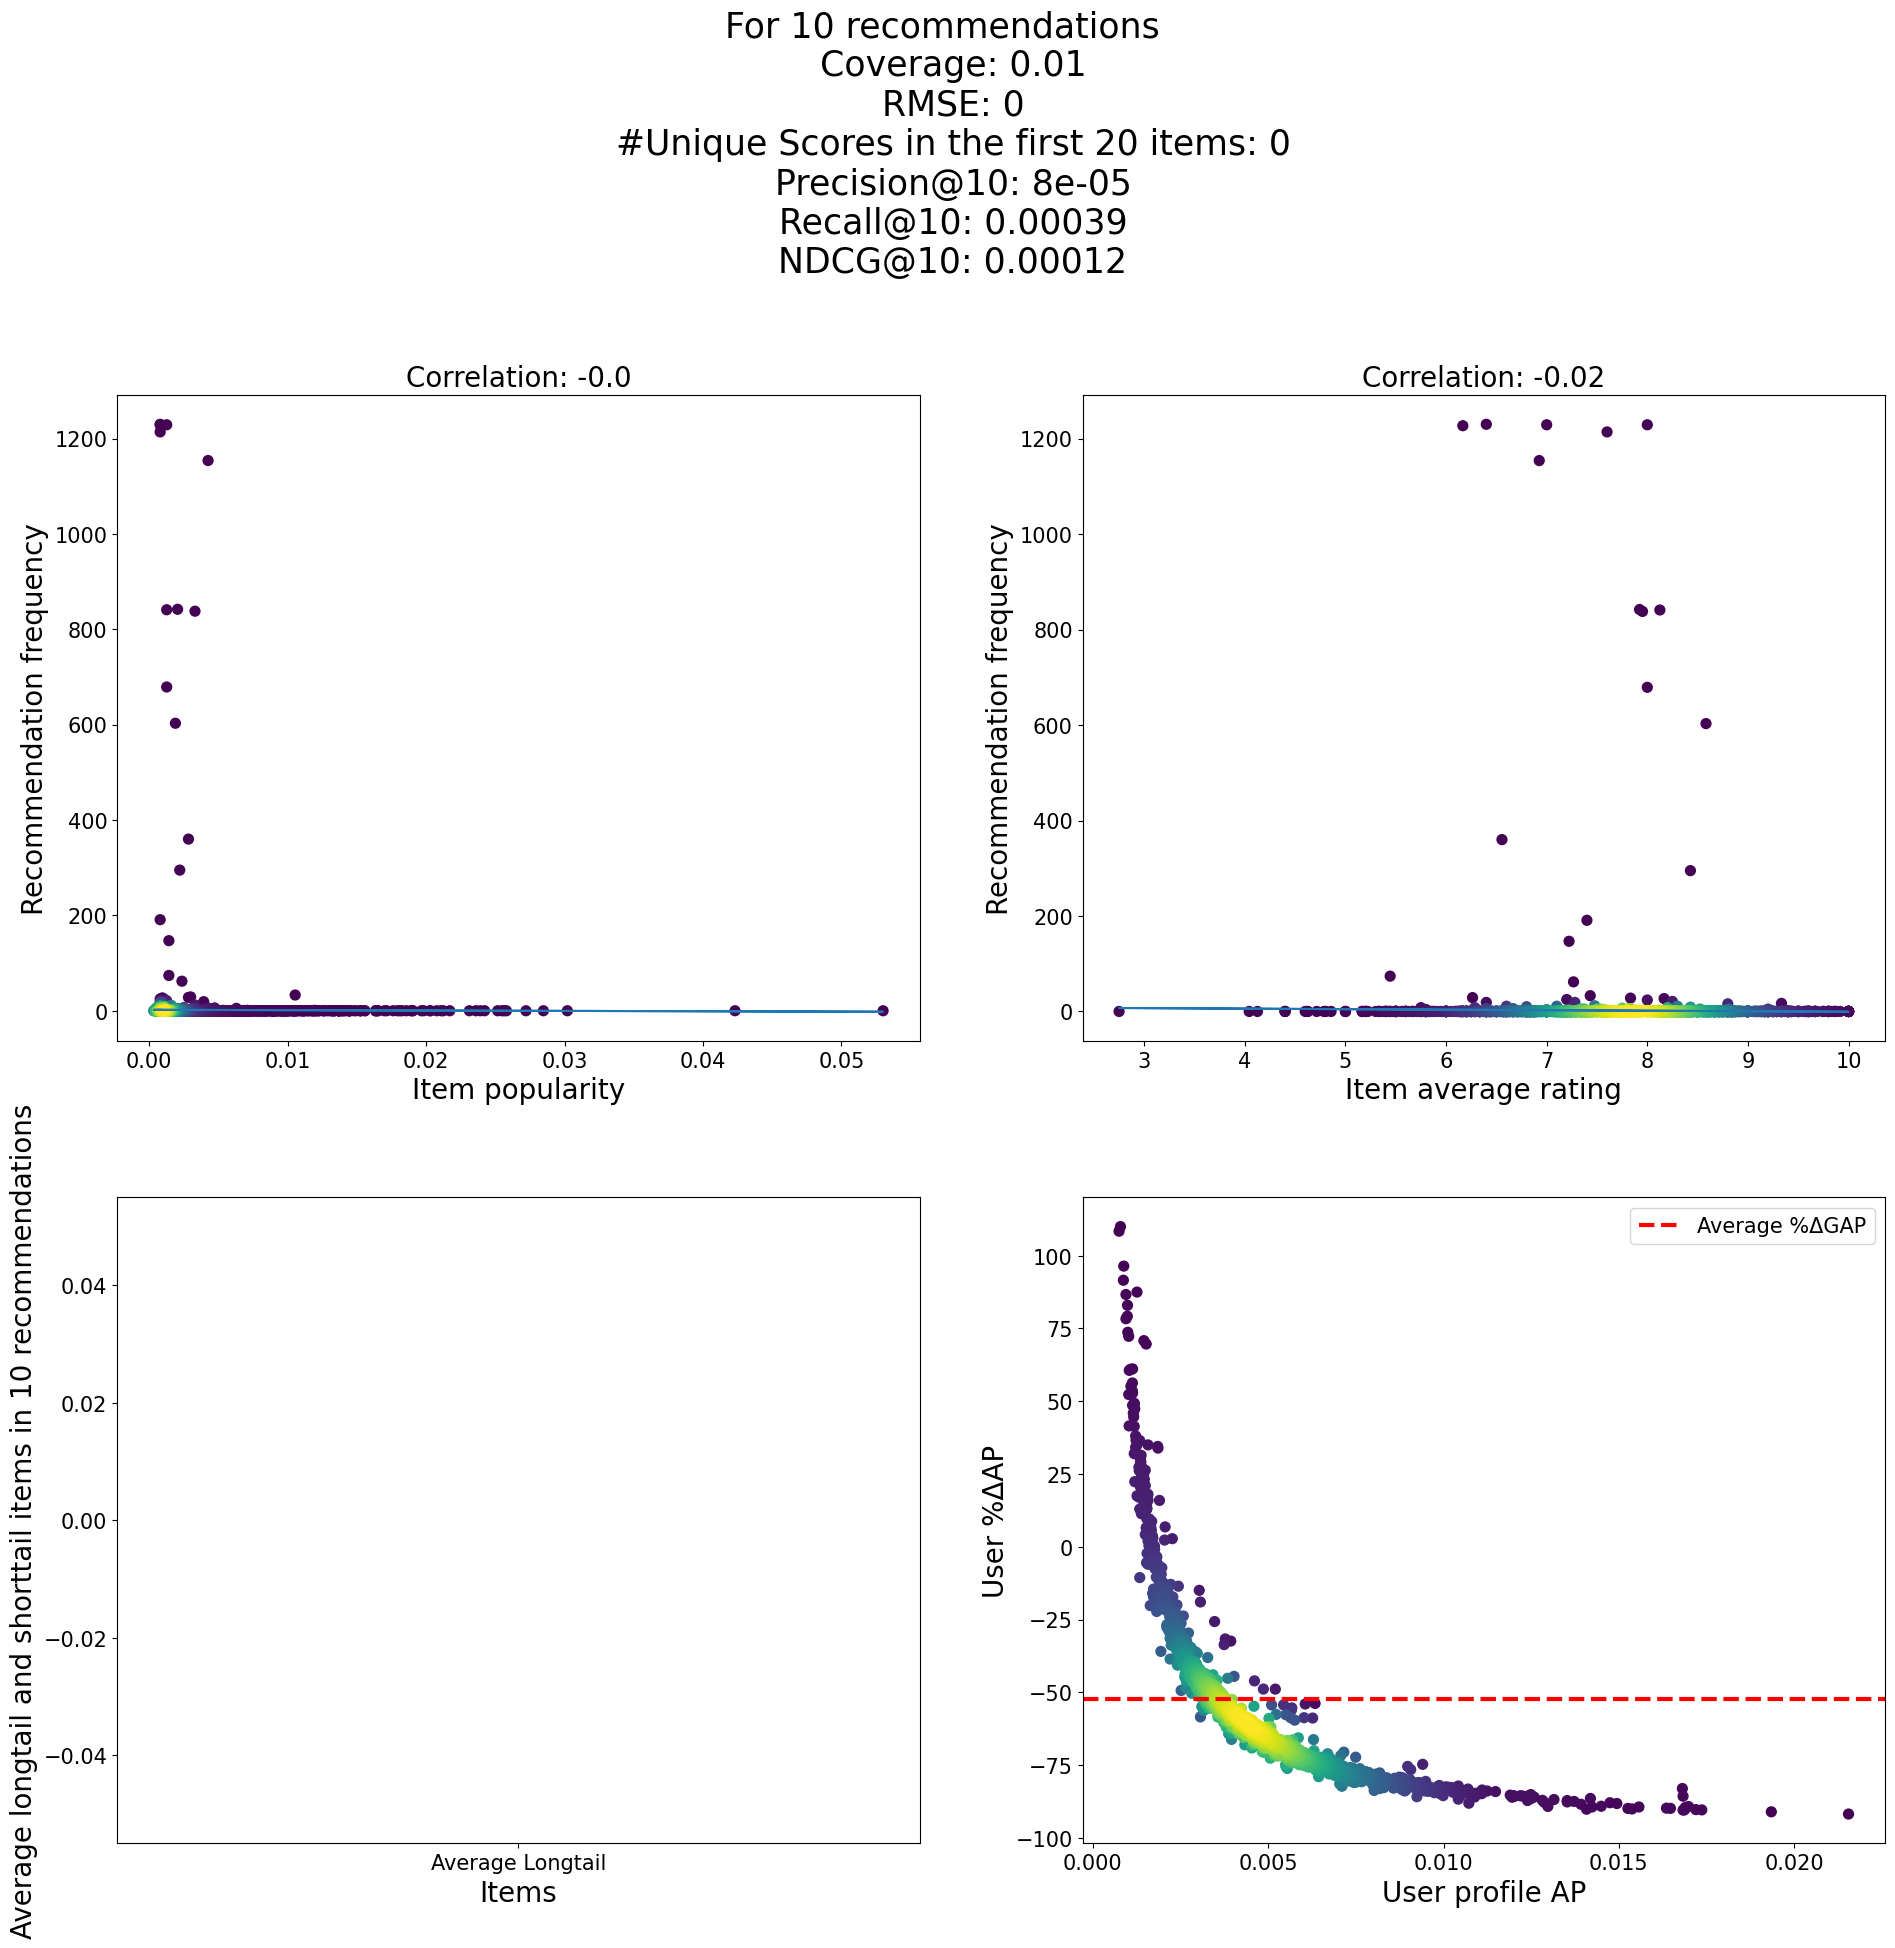

nr of longtail 2881
2.266719118804091


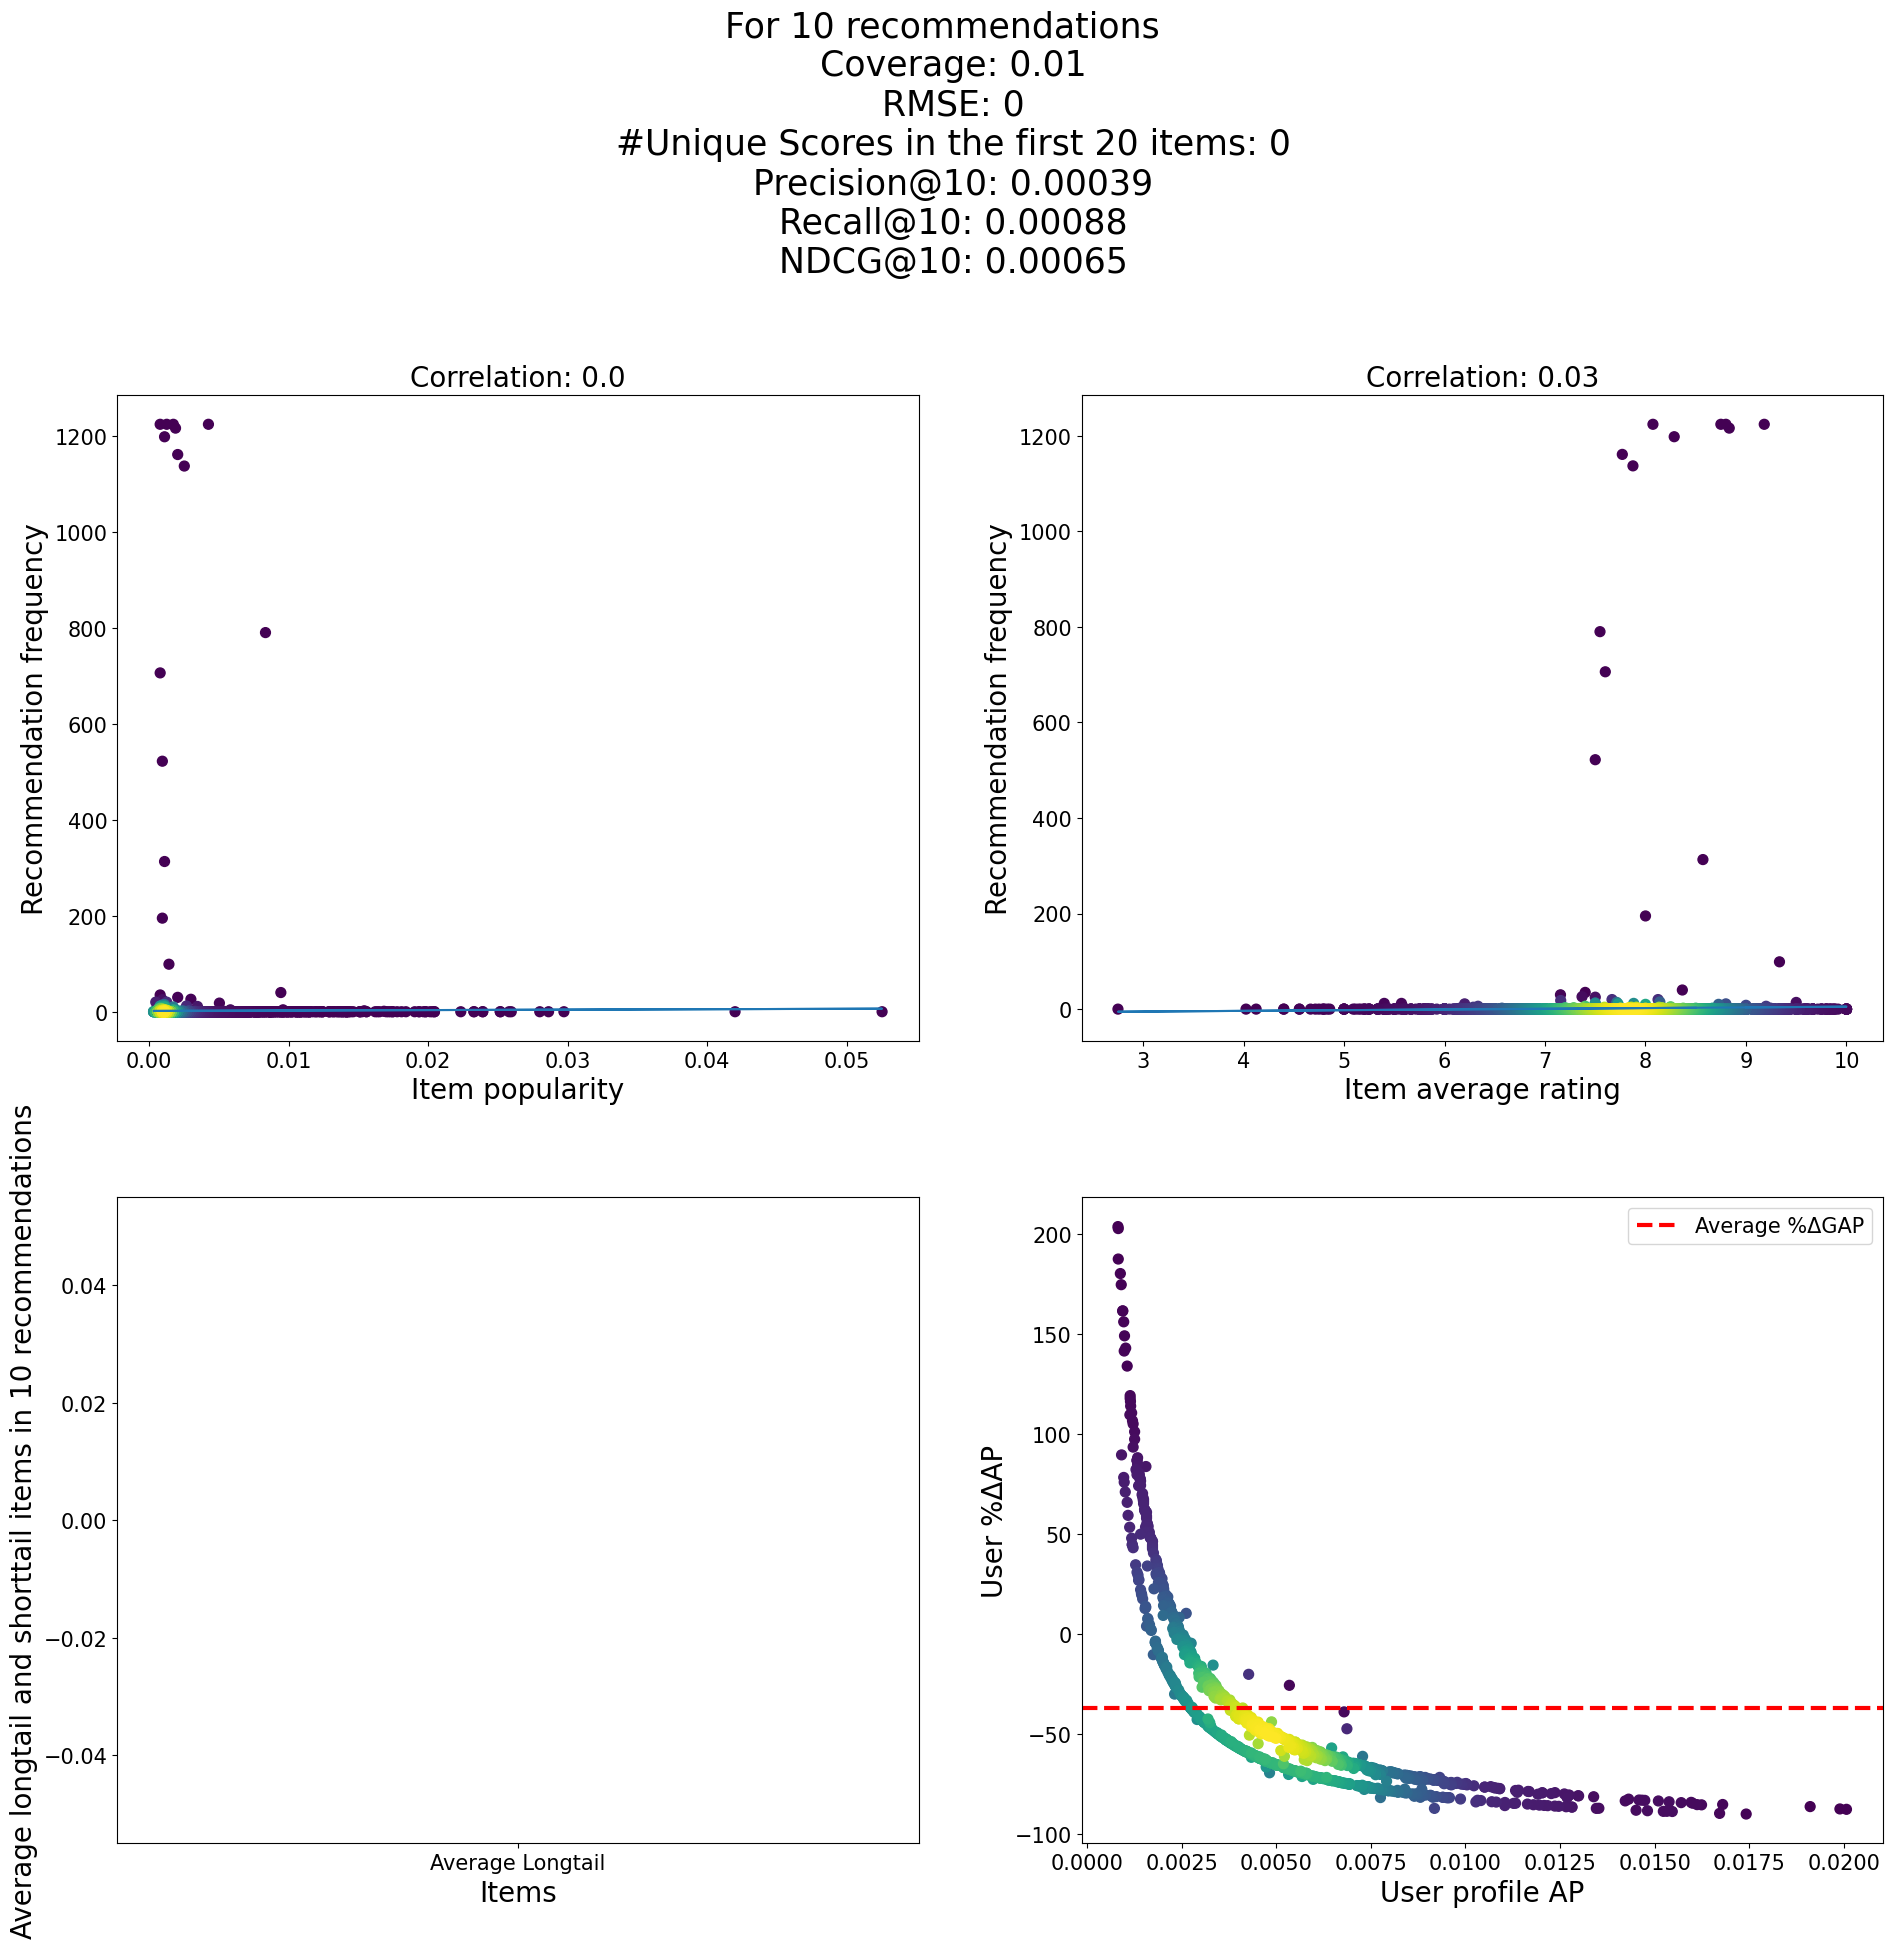

nr of longtail 6412
5.044846577498033


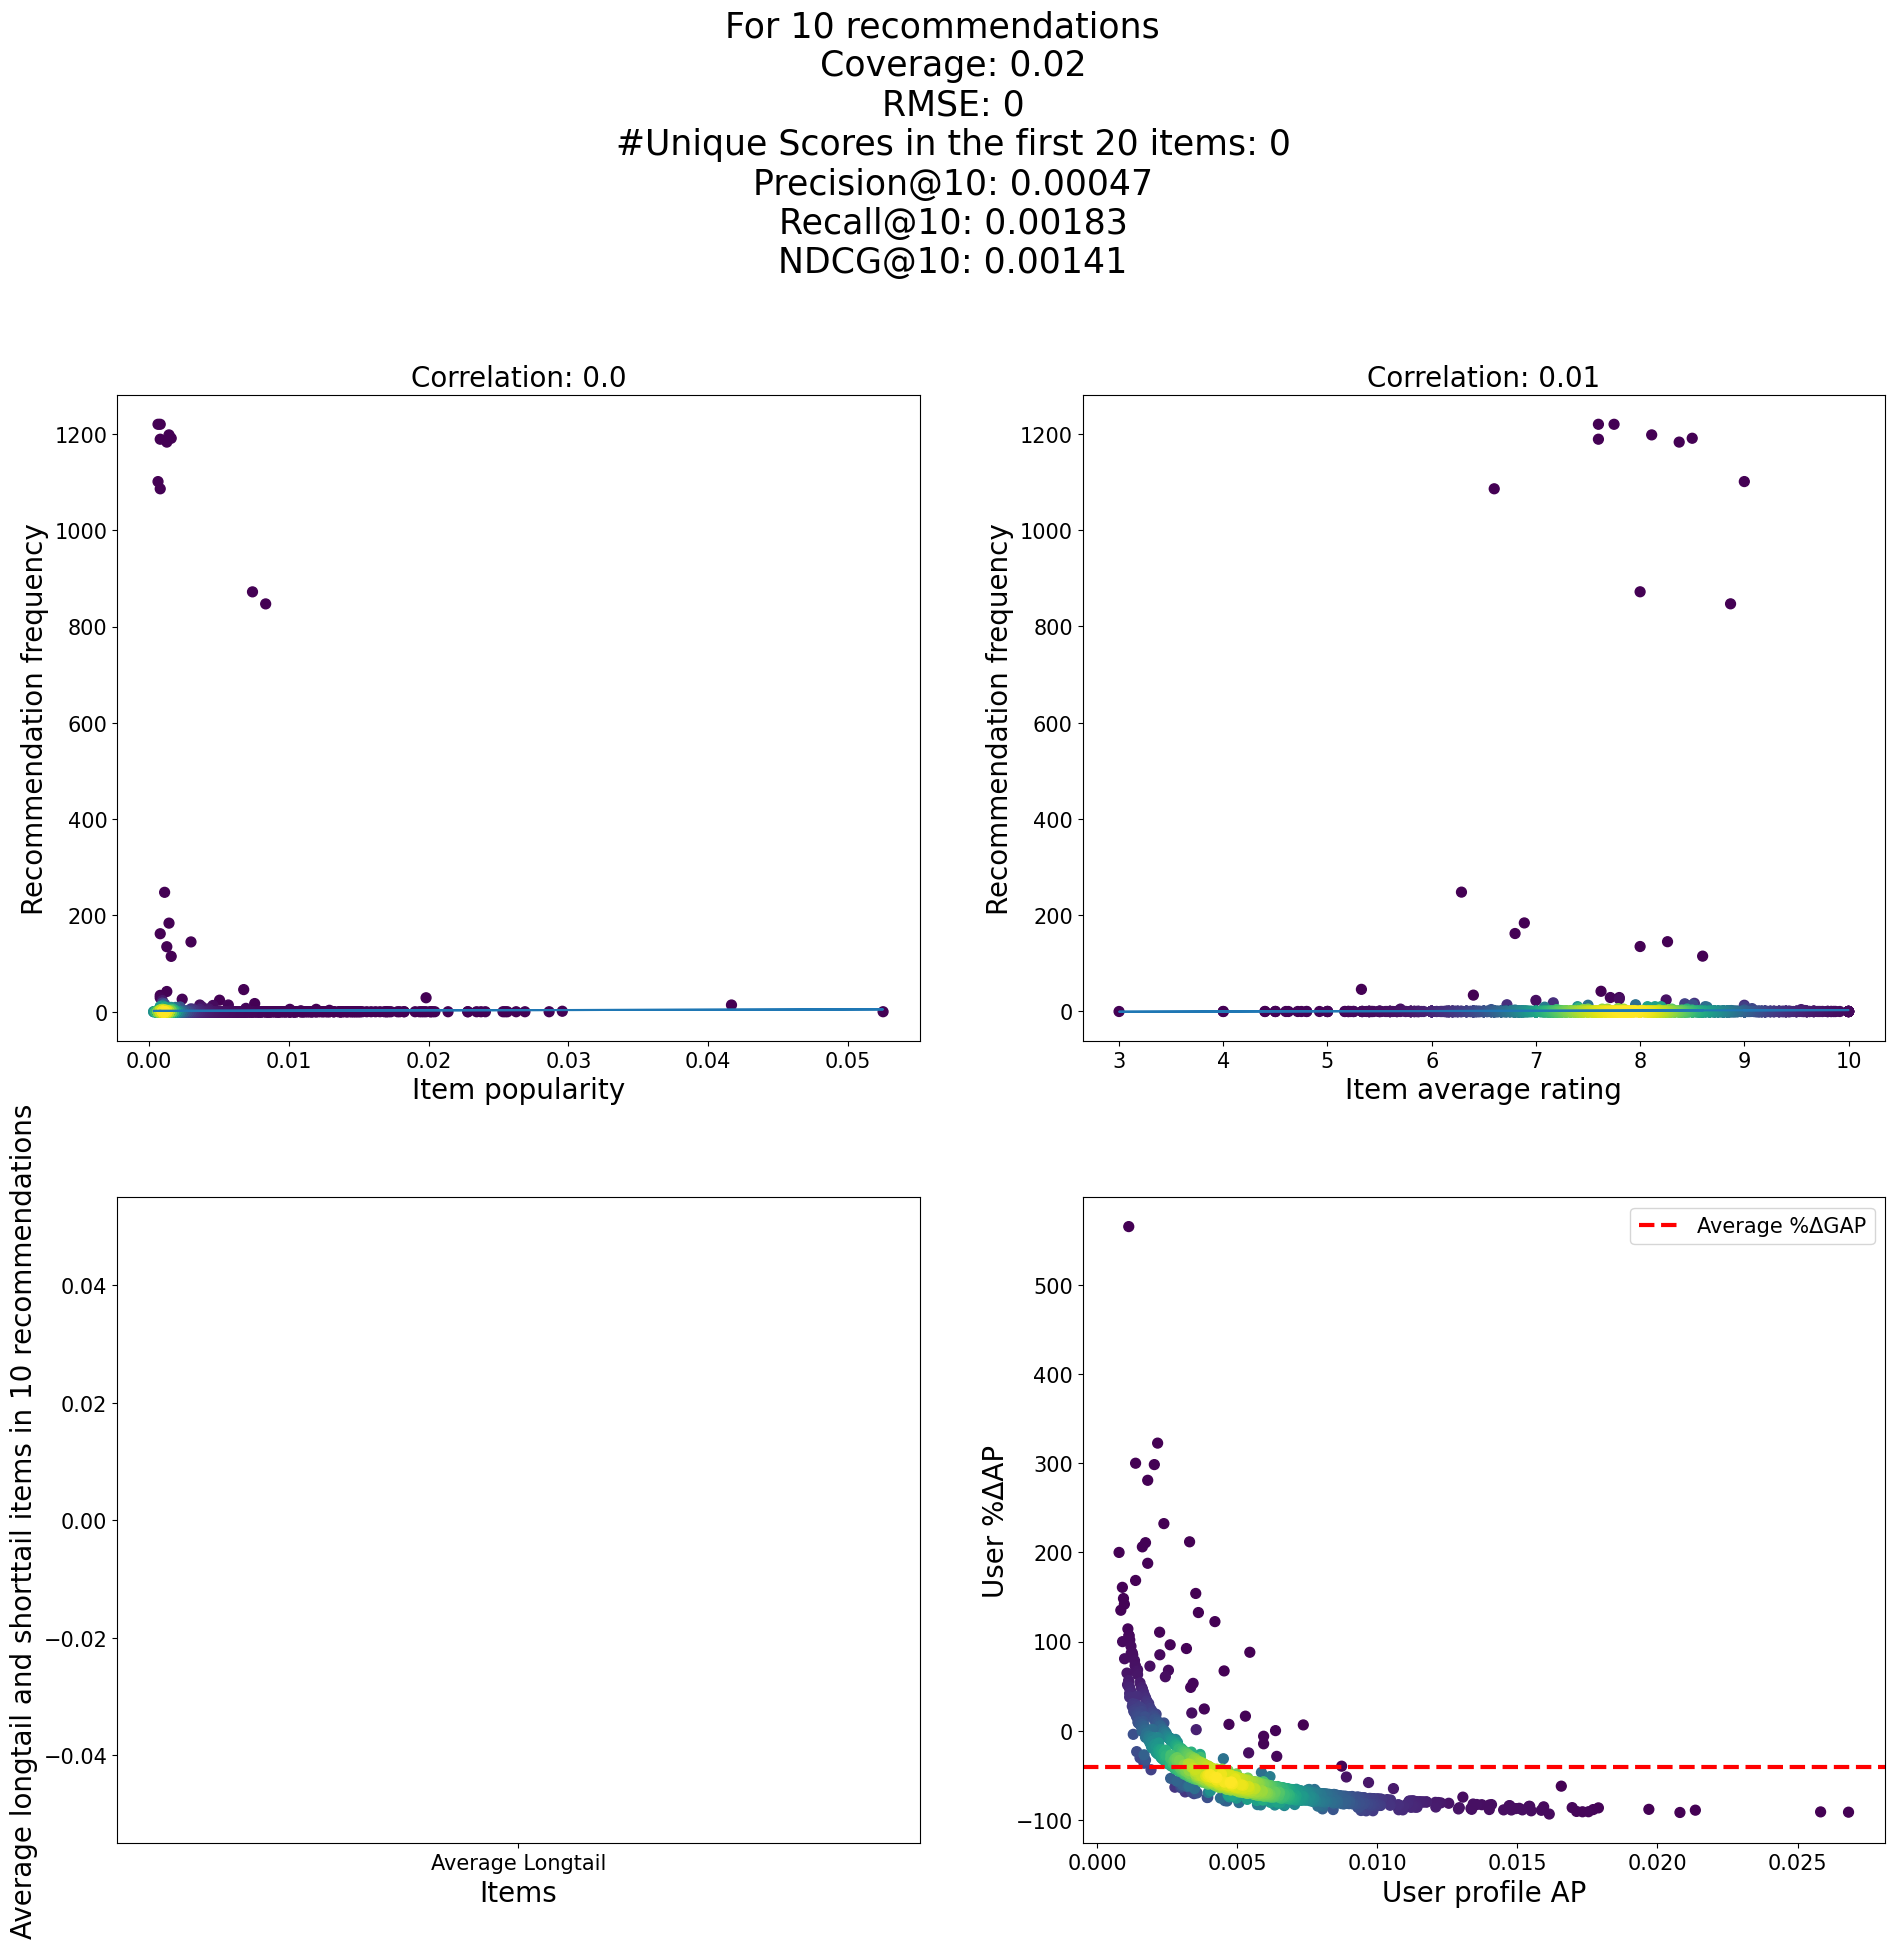

{'64-32': [{'pop_corr': (0.0030702361054695286, 0.7984333000476885), 'RMSE': 0, 'NDCG': 0.00044599829166003057, 'ARP': 0.002101658189256936, 'ave_PL': -41.64336511446936, 'ACLT': 4.514150943396227, 'AggDiv': 0.011125559890189278}, {'pop_corr': (-0.007721083142620722, 0.520723773848944), 'RMSE': 0, 'NDCG': 0.0007995678275370934, 'ARP': 0.0016115857603257228, 'ave_PL': -54.767156365727416, 'ACLT': 5.1084905660377355, 'AggDiv': 0.0109810720994076}, {'pop_corr': (0.011303300835455887, 0.34710955758989803), 'RMSE': 0, 'NDCG': 0.0003246986642048584, 'ARP': 0.002562598795950627, 'ave_PL': -27.552546840166794, 'ACLT': 5.70125786163522, 'AggDiv': 0.011125559890189278}, {'pop_corr': (-0.01397323808877188, 0.2451071111099814), 'RMSE': 0, 'NDCG': 0.0005619717302224863, 'ARP': 0.001152948799272567, 'ave_PL': -67.28143217913939, 'ACLT': 6.603461841070024, 'AggDiv': 0.010692096517844241}, {'pop_corr': (-0.0035844193480931916, 0.7655932043860816), 'RMSE': 0, 'NDCG': 0.0002936935331568753, 'ARP': 0.001

In [17]:
for mlp in mlp_values:
    metrics = []
    print(mlp)
    for fold in range(1,6):
        recs_location = 'results/'+data+str(fold)+'/recs/'
        data_location = 'data/'
        recs_file = recs_location + algorithm+'_seed=42_e=25_bs='+str(batch_size)+'_lr=0$1_umlp='+mlp+'_imlp='+mlp+'_negratio=5_reg=0$001_sim=cosine_it=25.tsv'
        train_file = data_location+data+'_fold_'+str(fold)+'_train.csv'
        test_file = data_location+data+'_fold_'+str(fold)+'_test.csv'
        # print(recs_file)
        recs_df = pd.read_csv(recs_file, sep='\t', header=None)
        recs_df.columns = ['user','item','rating']
        train_df = pd.read_csv(train_file)
        test_df = pd.read_csv(test_file)
        test_users = test_df.user.unique()
        test_recs = recs_df[recs_df.user.isin(test_users)].reset_index(drop=True)
        test_recs_grouped = test_recs.groupby([user_col])[item_col].apply(list)
        
        pop_bias= modelling_mf.calculate_pop_bias_per_item(all_items, item_col, user_col, predict_col, train_df, recs=test_recs)
        GAP_vs_GAP = modelling_mf.calculate_ave_pop_per_user(test_users, item_col, user_col, pop_bias, train_df, test_recs_grouped)
        pop_corr = modelling_mf.calculate_pop_correlation(pop_bias)
        precision, recall, ndcg = modelling_mf.calculate_topn_metrics(test_recs,test_df)
        AggDiv = modelling_mf.evaluate_item_coverage(pop_bias["recommendation"].values)
        ARP, ave_PL, ACLT = modelling_mf.calculate_all_pb_metrics(pop_bias, test_users, item_col, user_col, train_df, test_recs_grouped, test_recs)
        metrics_dict = {"pop_corr":pop_corr, "RMSE":0, 'NDCG':ndcg,"ARP":ARP, "ave_PL": ave_PL, "ACLT": ACLT, "AggDiv": AggDiv}
        metrics.append(metrics_dict) # per combination of mlp-bs, and per fold
        pop_biases = [pop_bias]
        
        modelling_mf.plot_results(pop_biases.copy(), 
                 GAP_vs_GAP.copy(), algorithm,
                 0, 
                 precision, 
                 recall,
                 ndcg,
                 0,
                 0,
                 cv=False, 
                 n=10, 
                 args='fold'+str(fold), data_strategy=data, save_plot=False)
        
    full_metrics_dict[mlp] = metrics
    print(full_metrics_dict)

#### Uniformly random

In [ ]:
j = 0 # only thing that needs to change

In [ ]:
ratings = generate_data(strategy = data_strategies[j],
                            copying_dataset = fairbook_ratings,
                            user_perc = 0.2)
all_items=set(ratings.item.unique())
full_metrics_dict = {}

In [ ]:
for mlp in mlp_values:
    for batch_size in batch_size_values:
        metrics = []
        print(mlp, batch_size)
        for fold in range(1,6):
            recs_location = 'results/'+data_strategies[j]+str(fold)+'/recs/'
            data_location = 'data/'+data_strategies[j]+str(fold)+'/'
            recs_file = recs_location + algorithm+'_seed=42_e=10_bs='+batch_size+'_lr=0$0001_umlp='+mlp+'_imlp='+mlp+'_negratio=5_reg=0$001_sim=cosine_it=10.tsv'
            train_file = data_location+data_strategies[j]+'_fold_'+str(fold)+'_train.csv'
            test_file = data_location+data_strategies[j]+'_fold_'+str(fold)+'_test.csv'
            # print(recs_file)
            recs_df = pd.read_csv(recs_file, sep='\t', header=None)
            recs_df.columns = ['user','item','rating']
            train_df = pd.read_csv(train_file)
            test_df = pd.read_csv(test_file)
            test_users = test_df.user.unique()
            test_recs = recs_df[recs_df.user.isin(test_users)].reset_index(drop=True)
            test_recs_grouped = test_recs.groupby([user_col])[item_col].apply(list)
            
            pop_bias= modelling_mf.calculate_pop_bias_per_item(all_items, item_col, user_col, predict_col, train_df, recs=test_recs)
            GAP_vs_GAP = modelling_mf.calculate_ave_pop_per_user(test_users, item_col, user_col, pop_bias, train_df, test_recs_grouped)
            pop_corr = modelling_mf.calculate_pop_correlation(pop_bias)
            precision, recall, ndcg = modelling_mf.calculate_topn_metrics(test_recs,test_df)
            AggDiv = modelling_mf.evaluate_item_coverage(pop_bias["recommendation"].values)
            ARP, ave_PL, ACLT = modelling_mf.calculate_all_pb_metrics(pop_bias, test_users, item_col, user_col, train_df, test_recs_grouped, test_recs)
            metrics_dict = {"pop_corr":pop_corr, "RMSE":0, 'NDCG':ndcg,"ARP":ARP, "ave_PL": ave_PL, "ACLT": ACLT, "AggDiv": AggDiv}
            metrics.append(metrics_dict) # per combination of mlp-bs, and per fold
            pop_biases = [pop_bias]
            
            modelling_mf.plot_results(pop_biases.copy(), 
                     GAP_vs_GAP.copy(), algorithm,
                     0, 
                     precision, 
                     recall,
                     ndcg,
                     0,
                     0,
                     cv=False, 
                     n=10, 
                     args='fold'+str(fold), data_strategy=data_strategies[j], save_plot=False)
            
        full_metrics_dict[(mlp, batch_size)] = metrics
        print(full_metrics_dict)

In [ ]:
ur_metrics = full_metrics_dict.copy() # not done

#### Popularity good

In [ ]:
j = 1 # only thing that needs to change

In [ ]:
ratings = generate_data(strategy = data_strategies[j],
                            copying_dataset = fairbook_ratings,
                            user_perc = 0.2)
all_items=set(ratings.item.unique())
full_metrics_dict = {}

In [ ]:
for mlp in mlp_values:
    for batch_size in batch_size_values:
        metrics = []
        print(mlp, batch_size)
        for fold in range(1,6):
            recs_location = 'results/'+data_strategies[j]+str(fold)+'/recs/'
            data_location = 'data/'+data_strategies[j]+str(fold)+'/'
            recs_file = recs_location + algorithm+'_seed=42_e=10_bs='+batch_size+'_lr=0$0001_umlp='+mlp+'_imlp='+mlp+'_negratio=5_reg=0$001_sim=cosine_it=10.tsv'
            train_file = data_location+data_strategies[j]+'_fold_'+str(fold)+'_train.csv'
            test_file = data_location+data_strategies[j]+'_fold_'+str(fold)+'_test.csv'
            # print(recs_file)
            recs_df = pd.read_csv(recs_file, sep='\t', header=None)
            recs_df.columns = ['user','item','rating']
            train_df = pd.read_csv(train_file)
            test_df = pd.read_csv(test_file)
            test_users = test_df.user.unique()
            test_recs = recs_df[recs_df.user.isin(test_users)].reset_index(drop=True)
            test_recs_grouped = test_recs.groupby([user_col])[item_col].apply(list)
            
            pop_bias= modelling_mf.calculate_pop_bias_per_item(all_items, item_col, user_col, predict_col, train_df, recs=test_recs)
            GAP_vs_GAP = modelling_mf.calculate_ave_pop_per_user(test_users, item_col, user_col, pop_bias, train_df, test_recs_grouped)
            pop_corr = modelling_mf.calculate_pop_correlation(pop_bias)
            precision, recall, ndcg = modelling_mf.calculate_topn_metrics(test_recs,test_df)
            AggDiv = modelling_mf.evaluate_item_coverage(pop_bias["recommendation"].values)
            ARP, ave_PL, ACLT = modelling_mf.calculate_all_pb_metrics(pop_bias, test_users, item_col, user_col, train_df, test_recs_grouped, test_recs)
            metrics_dict = {"pop_corr":pop_corr, "RMSE":0, 'NDCG':ndcg,"ARP":ARP, "ave_PL": ave_PL, "ACLT": ACLT, "AggDiv": AggDiv}
            metrics.append(metrics_dict) # per combination of mlp-bs, and per fold
            pop_biases = [pop_bias]
            
            modelling_mf.plot_results(pop_biases.copy(), 
                     GAP_vs_GAP.copy(), algorithm,
                     0, 
                     precision, 
                     recall,
                     ndcg,
                     0,
                     0,
                     cv=False, 
                     n=10, 
                     args='fold'+str(fold), data_strategy=data_strategies[j], save_plot=False)
            
        full_metrics_dict[(mlp, batch_size)] = metrics
        print(full_metrics_dict)

In [ ]:
pg_metrics = full_metrics_dict.copy()

#### Popularity bad

In [ ]:
j = 2 # only thing that needs to change

In [ ]:
ratings = generate_data(strategy = data_strategies[j],
                            copying_dataset = fairbook_ratings,
                            user_perc = 0.2)
all_items=set(ratings.item.unique())
full_metrics_dict = {}

In [ ]:
for mlp in mlp_values:
    for batch_size in batch_size_values:
        metrics = []
        print(mlp, batch_size)
        for fold in range(1,6):
            recs_location = 'results/'+data_strategies[j]+str(fold)+'/recs/'
            data_location = 'data/'+data_strategies[j]+str(fold)+'/'
            recs_file = recs_location + algorithm+'_seed=42_e=10_bs='+batch_size+'_lr=0$0001_umlp='+mlp+'_imlp='+mlp+'_negratio=5_reg=0$001_sim=cosine_it=10.tsv'
            train_file = data_location+data_strategies[j]+'_fold_'+str(fold)+'_train.csv'
            test_file = data_location+data_strategies[j]+'_fold_'+str(fold)+'_test.csv'
            # print(recs_file)
            recs_df = pd.read_csv(recs_file, sep='\t', header=None)
            recs_df.columns = ['user','item','rating']
            train_df = pd.read_csv(train_file)
            test_df = pd.read_csv(test_file)
            test_users = test_df.user.unique()
            test_recs = recs_df[recs_df.user.isin(test_users)].reset_index(drop=True)
            test_recs_grouped = test_recs.groupby([user_col])[item_col].apply(list)
            
            pop_bias= modelling_mf.calculate_pop_bias_per_item(all_items, item_col, user_col, predict_col, train_df, recs=test_recs)
            GAP_vs_GAP = modelling_mf.calculate_ave_pop_per_user(test_users, item_col, user_col, pop_bias, train_df, test_recs_grouped)
            pop_corr = modelling_mf.calculate_pop_correlation(pop_bias)
            precision, recall, ndcg = modelling_mf.calculate_topn_metrics(test_recs,test_df)
            AggDiv = modelling_mf.evaluate_item_coverage(pop_bias["recommendation"].values)
            ARP, ave_PL, ACLT = modelling_mf.calculate_all_pb_metrics(pop_bias, test_users, item_col, user_col, train_df, test_recs_grouped, test_recs)
            metrics_dict = {"pop_corr":pop_corr, "RMSE":0, 'NDCG':ndcg,"ARP":ARP, "ave_PL": ave_PL, "ACLT": ACLT, "AggDiv": AggDiv}
            metrics.append(metrics_dict) # per combination of mlp-bs, and per fold
            pop_biases = [pop_bias]
            
            modelling_mf.plot_results(pop_biases.copy(), 
                     GAP_vs_GAP.copy(), algorithm,
                     0, 
                     precision, 
                     recall,
                     ndcg,
                     0,
                     0,
                     cv=False, 
                     n=10, 
                     args='fold'+str(fold), data_strategy=data_strategies[j], save_plot=False)
            
        full_metrics_dict[(mlp, batch_size)] = metrics
        print(full_metrics_dict)

In [ ]:
pb_metrics = full_metrics_dict.copy()

#### Popularity good big

In [ ]:
j = 3 # only thing that needs to change

In [ ]:
ratings = generate_data(strategy = data_strategies[j],
                            copying_dataset = fairbook_ratings,
                            user_perc = 0.2)
all_items=set(ratings.item.unique())
full_metrics_dict = {}

In [ ]:
alt = 'popularity_good_big' # different title due to mistake
for mlp in mlp_values:
    for batch_size in batch_size_values:
        metrics = []
        print(mlp, batch_size)
        for fold in range(1,6):
            recs_location = 'results/'+alt+str(fold)+'/recs/'
            data_location = 'data/'+alt+str(fold)+'/'
            recs_file = recs_location + algorithm+'_seed=42_e=10_bs='+batch_size+'_lr=0$0001_umlp='+mlp+'_imlp='+mlp+'_negratio=5_reg=0$001_sim=cosine_it=10.tsv'
            train_file = data_location+data_strategies[j]+'_fold_'+str(fold)+'_train.csv'
            test_file = data_location+data_strategies[j]+'_fold_'+str(fold)+'_test.csv'
            # print(recs_file)
            recs_df = pd.read_csv(recs_file, sep='\t', header=None)
            recs_df.columns = ['user','item','rating']
            train_df = pd.read_csv(train_file)
            test_df = pd.read_csv(test_file)
            test_users = test_df.user.unique()
            test_recs = recs_df[recs_df.user.isin(test_users)].reset_index(drop=True)
            test_recs_grouped = test_recs.groupby([user_col])[item_col].apply(list)
            
            pop_bias= modelling_mf.calculate_pop_bias_per_item(all_items, item_col, user_col, predict_col, train_df, recs=test_recs)
            GAP_vs_GAP = modelling_mf.calculate_ave_pop_per_user(test_users, item_col, user_col, pop_bias, train_df, test_recs_grouped)
            pop_corr = modelling_mf.calculate_pop_correlation(pop_bias)
            precision, recall, ndcg = modelling_mf.calculate_topn_metrics(test_recs,test_df)
            AggDiv = modelling_mf.evaluate_item_coverage(pop_bias["recommendation"].values)
            ARP, ave_PL, ACLT = modelling_mf.calculate_all_pb_metrics(pop_bias, test_users, item_col, user_col, train_df, test_recs_grouped, test_recs)
            metrics_dict = {"pop_corr":pop_corr, "RMSE":0, 'NDCG':ndcg,"ARP":ARP, "ave_PL": ave_PL, "ACLT": ACLT, "AggDiv": AggDiv}
            metrics.append(metrics_dict) # per combination of mlp-bs, and per fold
            pop_biases = [pop_bias]
            
            modelling_mf.plot_results(pop_biases.copy(), 
                     GAP_vs_GAP.copy(), algorithm,
                     0, 
                     precision, 
                     recall,
                     ndcg,
                     0,
                     0,
                     cv=False, 
                     n=10, 
                     args='fold'+str(fold), data_strategy=data_strategies[j], save_plot=False)
            
        full_metrics_dict[(mlp, batch_size)] = metrics
        print(full_metrics_dict)

In [ ]:
pg_bp_metrics = full_metrics_dict.copy()

#### Popularity bad big

In [ ]:
j = 4 # only thing that needs to change

In [ ]:
ratings = generate_data(strategy = data_strategies[j],
                            copying_dataset = fairbook_ratings,
                            user_perc = 0.2)
all_items=set(ratings.item.unique())
full_metrics_dict = {}

In [ ]:
alt = 'popularity_bad_big' # different title due to mistake
for mlp in mlp_values:
    for batch_size in batch_size_values:
        metrics = []
        print(mlp, batch_size)
        for fold in range(1,6):
            recs_location = 'results/'+alt+str(fold)+'/recs/'
            data_location = 'data/'+alt+str(fold)+'/'
            recs_file = recs_location + algorithm+'_seed=42_e=10_bs='+batch_size+'_lr=0$0001_umlp='+mlp+'_imlp='+mlp+'_negratio=5_reg=0$001_sim=cosine_it=10.tsv'
            train_file = data_location+data_strategies[j]+'_fold_'+str(fold)+'_train.csv'
            test_file = data_location+data_strategies[j]+'_fold_'+str(fold)+'_test.csv'
            # print(recs_file)
            recs_df = pd.read_csv(recs_file, sep='\t', header=None)
            recs_df.columns = ['user','item','rating']
            train_df = pd.read_csv(train_file)
            test_df = pd.read_csv(test_file)
            test_users = test_df.user.unique()
            test_recs = recs_df[recs_df.user.isin(test_users)].reset_index(drop=True)
            test_recs_grouped = test_recs.groupby([user_col])[item_col].apply(list)
            
            pop_bias= modelling_mf.calculate_pop_bias_per_item(all_items, item_col, user_col, predict_col, train_df, recs=test_recs)
            GAP_vs_GAP = modelling_mf.calculate_ave_pop_per_user(test_users, item_col, user_col, pop_bias, train_df, test_recs_grouped)
            pop_corr = modelling_mf.calculate_pop_correlation(pop_bias)
            precision, recall, ndcg = modelling_mf.calculate_topn_metrics(test_recs,test_df)
            AggDiv = modelling_mf.evaluate_item_coverage(pop_bias["recommendation"].values)
            ARP, ave_PL, ACLT = modelling_mf.calculate_all_pb_metrics(pop_bias, test_users, item_col, user_col, train_df, test_recs_grouped, test_recs)
            metrics_dict = {"pop_corr":pop_corr, "RMSE":0, 'NDCG':ndcg,"ARP":ARP, "ave_PL": ave_PL, "ACLT": ACLT, "AggDiv": AggDiv}
            metrics.append(metrics_dict) # per combination of mlp-bs, and per fold
            pop_biases = [pop_bias]
            
            modelling_mf.plot_results(pop_biases.copy(), 
                     GAP_vs_GAP.copy(), algorithm,
                     0, 
                     precision, 
                     recall,
                     ndcg,
                     0,
                     0,
                     cv=False, 
                     n=10, 
                     args='fold'+str(fold), data_strategy=data_strategies[j], save_plot=False)
            
        full_metrics_dict[(mlp, batch_size)] = metrics
        print(full_metrics_dict)

In [ ]:
pb_bp_metrics = full_metrics_dict.copy()

## Combine results

Now I have to figure out how to combine the results in a way that makes sense...

In [ ]:
metrics_list = [ur_metrics, pg_metrics, pb_metrics, pg_bp_metrics, pb_bp_metrics]

In [ ]:
relevant_values = ["pop_corr", "ARP", "ave_PL", "AggDiv", "NDCG"]

In [ ]:
params = list(ur_metrics.keys())

In [ ]:
metrics_list[0]

In [ ]:
strategy_list = []
for strategy in metrics_list:
    curr_list = []
    for param in params: # for every instantiation of the algo
        # print(strategy)
        met = strategy[param]
    
        curr_dict = {}
        for value in relevant_values:
            ave_value = sum(d[value] for d in met) / len(met)
            # print(ave_value)
            curr_dict[value] = ave_value
            
        curr_list.append(curr_dict)
    strategy_list.append(curr_list)

In [ ]:
strategy_list

In [ ]:
ds = ["Scenario 1", "Scenario 2", "Scenario 3", "Scenario 4", "Scenario 5"]

In [ ]:
layers = np.unique([x[0] for x in params])

In [ ]:
batches = np.unique([x[1] for x in params])

In [ ]:
index = pd.MultiIndex.from_product(
    [ds, layers, batches], names=["DataStrategy", "Layers", "Batches"]
).drop_duplicates()

In [ ]:

unlisted_sl = list(chain(*strategy_list))

In [ ]:
result = pd.DataFrame(unlisted_sl, index=index)

In [ ]:
print(result.round(3).to_latex())